## Importing the necessary modules

In [1]:
!pip install torchview
# To clear the terminal
from IPython.display import clear_output
clear_output()

In [2]:
import kagglehub
# Loading the dataset
root = kagglehub.dataset_download("splcher/animefacedataset")

# PyTorch
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import spectral_norm
from torchvision import transforms
from torchview import draw_graph

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import warnings
import time
from PIL import Image
warnings.filterwarnings('ignore')

root = os.path.join(root,'images')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
normal_params = [np.array([0.5,0.5,0.5]), np.array([0.5,0.5,0.5])] # Mean and std
print('Device : ',device)

Device :  cuda


## Custom Weights initializer
#### to stabalize GAN training

In [3]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    # To account for BatchNorm and InstanceNorm ( unused )
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.InstanceNorm2d):
        if m.weight is not None:
            nn.init.normal_(m.weight, 1.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

## Dataset
#### Importing and processing the dataset ino the DataLoader

In [4]:
# Custom dataset Class - returns a real image and a normalized random tensor
class AnimeFaces(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform
        self.locs = os.listdir(data_dir)

    def __len__(self):
        return len(self.locs)

    def __getitem__(self, idx):
        path = os.path.join(self.data_dir, self.locs[idx])
        img = Image.open(path).convert("RGB")
        img = self.transform(img) if self.transform else img
        return img
# Composing the transform    
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=normal_params[0], std=normal_params[1])
])
# Loading the dataset
data = AnimeFaces(root, transform)
train = DataLoader(dataset=data, batch_size=128, shuffle=True , num_workers=4)
num_batches = len(train)
print("No. of training batches : ", num_batches)

No. of training batches :  497


## Wasserstein loss function

#### The Wasserstein loss solves a major drawback encountered in trainig a DCGAN, that is, vanashing gradients. It solves it by replacing a binary discriminator with a critic that computes the wasserstein metric ( Earth Mover's distance )

$$
L_{D} = - \mathbb{E}_{x \sim p_{r}}[D(x)] 
\;+\; \mathbb{E}_{z \sim p_{z}}[D(G(z))] 
\;+\; \lambda \, \mathbb{E}_{\hat{x} \sim p_{\hat{x}}} \Big[ \big( \| \nabla_{\hat{x}} D(\hat{x}) \|_2 - 1 \big)^2 \Big]
$$

$$
L_{G} = - \mathbb{E}_{z \sim p_{z}}[D(G(z))]
$$

In [5]:
def wloss(D, real, fake, lambda_gp=10):
    eps = torch.rand(real.size(0), 1, 1, 1, device=real.device, requires_grad=True)
    mixed = eps * real + (1 - eps) * fake
    mixed_pred = D(mixed)
    grads = torch.autograd.grad(mixed_pred.sum(), mixed, create_graph=True)[0]
    gp = ((grads.view(grads.size(0), -1).norm(2, dim=1) - 1) ** 2).mean()
    real_pred = D(real)
    fake_pred = D(fake)
    return fake_pred.mean() - real_pred.mean() + lambda_gp * gp

## Hyperparameters

In [6]:
latent_dim = 100
learning_rate_order = 1e-5
start_time = time.time()
time_limit = 11.7 * 3600
epochs = np.arange(0, 100) + 1

## PixelNorm Class
$$
\text{PixelNorm}(x_{i,j,C}) = \frac{x_{i,j,C}}{\sqrt{\frac{1}{C} \sum_{c=1}^{C} x_{i,j,c}^{2} + \epsilon}}
$$

In [7]:
# Pixel Norm
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-10)

# function to generate normalized random noise
def rand_noise(batch = 1):
    noise = torch.randn(batch, latent_dim, device=device)
    noise = noise / (noise.norm(dim=1, keepdim=True) + 1e-10)
    return noise

# Function to see if the remaining time is enough or not ( to not reach kaggle's limit )
def not_enough_time():
    elapsed = time.time() - start_time
    return elapsed > time_limit

## Display Functions

In [8]:
random_noise = [rand_noise() for _ in range(6)]
# Used to generate images for validation
def valid_plot(G,epoch=0, rows=1, cols=6, random_noise=random_noise, save=True):
    with torch.inference_mode():
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        if epoch:
            plt.suptitle(f"Epoch: {epoch}")
        axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
        for idx in range(rows * cols):
            noise = G(random_noise[idx]).squeeze(0).permute(1, 2, 0).cpu().numpy()
            mean = np.array(normal_params[0]).reshape(1, 1, 3)
            std = np.array(normal_params[1]).reshape(1, 1, 3)
            noise = np.clip(noise * std + mean, 0, 1)
            axs[idx].imshow((noise * 255).astype(np.uint8))
            axs[idx].axis('off')
        plt.tight_layout()
        if save:
            plt.savefig(f'validation_image{epoch}')
        plt.show()

def plot_imgs(rows, cols, imgs):
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axs = axs.flatten()
    for idx in range(rows * cols):
        axs[idx].axis('off')
        axs[idx].imshow(imgs[idx])
    plt.tight_layout()
    plt.show()

## Generator Implementation

In [9]:
class UpBlockOne(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(in_channels, out_channels, 3,1,1),
            PixelNorm(),
            nn.PReLU()
        )
    def forward(self, x):
        return self.block(x)

class UpBlockTwo(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.p1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            PixelNorm(),
            nn.PReLU(),
        )
        self.p2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, (out_channels + in_channels) // 2, kernel_size=3, stride=1, padding=1),
            PixelNorm(),
            nn.PReLU(),
            nn.ConvTranspose2d((out_channels + in_channels) // 2, out_channels, kernel_size=4, stride=2, padding=1),
            PixelNorm(),
            nn.PReLU(),
        )
        self.b1 = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, stride=1, padding=1),
            PixelNorm(),
            nn.PReLU(),
        )

    def forward(self, x):
        y1 = self.p1(x)
        y2 = self.p2(x)
        y = torch.cat((y1, y2), dim=1)
        return self.b1(y)
        

class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Only output sizes written; in form (C, H), and H = W
        self.layerStart = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(latent_dim,100),
            PixelNorm(),
            nn.LeakyReLU(0.2),
            
            nn.Linear(100,100),
            PixelNorm(),
            nn.LeakyReLU(0.2),
            
            nn.Linear(100,512),
            PixelNorm(),
            nn.LeakyReLU(0.2),
            
            nn.Unflatten(1, (512,1,1)),
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=1, padding=0),
            PixelNorm(),
            nn.LeakyReLU(0.2),
        ) # -> (100,) -> (100,) -> (384,) -> (384, 1)
        
        self.dcgan1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            PixelNorm(),
            nn.PReLU(),

            UpBlockTwo(256, 128),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            PixelNorm(),
            nn.PReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            PixelNorm(),
            nn.PReLU()
        ) # -> (384, 1) -> (384, 4) -> (256, 8)
        
        self.dcgan2 = nn.Sequential(
            UpBlockOne(512, 256),
            UpBlockOne(256, 128),
            UpBlockOne(128, 64),
            UpBlockOne(64, 32)
        )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(64,3,3,1,1),
            nn.Tanh()
        ) # -> (64, 64) -> (3, 64)

    def forward(self, x):
        x = self.layerStart(x)
        y1 = self.dcgan1(x)
        y2 = self.dcgan2(x)
        y = torch.cat((y1,y2), dim=1)
        return self.conv1(y)

## Discriminator Implementaton

In [10]:
class Block(nn.Module): # Implements a skip connection, outputs of b1 added to b2
    def __init__(self, inp, out):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(inp,out,3,1,1),
            nn.LeakyReLU(0.2),
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(out,out,3,1,1),
            nn.LeakyReLU(0.2),
        )
        self.prelu = nn.PReLU()
        self.pool = nn.MaxPool2d(2,2)

    def forward(self,x):
        x = self.b1(x)
        return self.pool(self.prelu(x + self.b2(x)))

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Input size --> (*, 3, 64, 64)
        self.l1 = nn.Sequential(
            nn.Conv2d(3,64,3,1,1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),

            Block(64,128),  # -> (128, 16)
            Block(128,256), # -> (256, 8)
            Block(256,384), # -> (384, 4)
            nn.AdaptiveAvgPool2d((1,1)), # -> (384, 1)
            nn.Flatten(), # -> (384,)

            nn.Linear(384, 192), # -> (256,)
            nn.PReLU(),
            nn.Linear(192, 192), # -> (256,)
            nn.PReLU(),
            nn.Linear(192,1) # -> (1,)
        )
        
    def forward(self,x):
        return self.l1(x)

## Model Initialization

In [11]:
# Initializing the models
generator = Generator().to(device)
discriminator = Discriminator().to(device)
# Declaring the optimizers
optimizerG = optim.Adam(generator.parameters(), lr=7.5*learning_rate_order, betas=(0.0, 0.99))
optimizerD = optim.Adam(discriminator.parameters(), lr=3*learning_rate_order, betas=(0.0, 0.99))
# Setting up the schedulers
schedG = optim.lr_scheduler.CosineAnnealingLR(optimizerG, len(epochs) * num_batches, 5*learning_rate_order)
schedD = optim.lr_scheduler.CosineAnnealingLR(optimizerD, len(epochs) * num_batches, 2*learning_rate_order)
# Custom weights initializer for stability
generator.apply(weights_init)
discriminator.apply(weights_init)
# Printing the model summary
print(generator)
print(discriminator)

Generator(
  (layerStart): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): PixelNorm()
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): PixelNorm()
    (6): LeakyReLU(negative_slope=0.2)
    (7): Linear(in_features=100, out_features=512, bias=True)
    (8): PixelNorm()
    (9): LeakyReLU(negative_slope=0.2)
    (10): Unflatten(dim=1, unflattened_size=(512, 1, 1))
    (11): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
    (12): PixelNorm()
    (13): LeakyReLU(negative_slope=0.2)
  )
  (dcgan1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): PixelNorm()
    (2): PReLU(num_parameters=1)
    (3): UpBlockTwo(
      (p1): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): PixelNorm()
        (2): PReLU(num_parameters=1

## Displaying The architecture for the generator

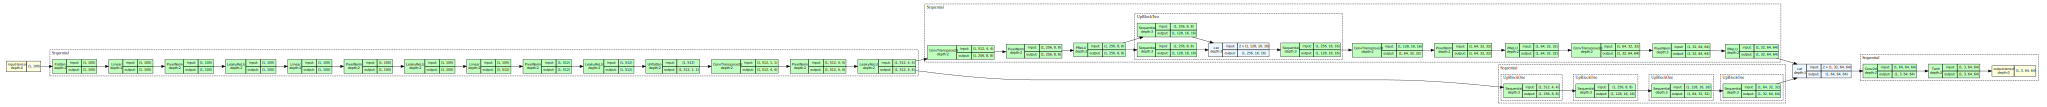

In [12]:
model_graph = draw_graph(
    generator, 
    input_size=(1,latent_dim),
    expand_nested=True,
    graph_name='generator'
)
model_graph.visual_graph.attr(rankdir="LR")
model_graph.visual_graph.attr(size="100,60")
model_graph.visual_graph

## Displaying The architecture for the critic

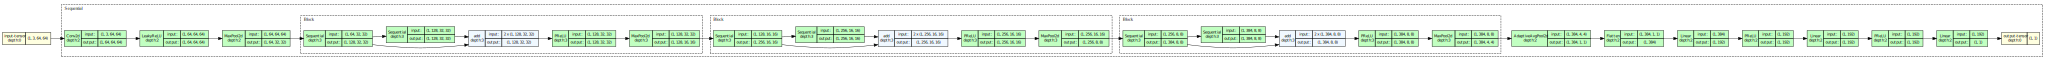

In [13]:
model_graph = draw_graph(
    discriminator, 
    input_size=(1,3,64,64),
    expand_nested=True,
    graph_name='discriminator'
)
model_graph.visual_graph.attr(rankdir="LR")
model_graph.visual_graph.attr(size="100,60")
model_graph.visual_graph

## Function to train the Models

In [14]:
def train_now():
    # Number of times the critic steps per generator step
    crts = 6
    
    for epoch in epochs:
        # Setting them up for training
        generator.train()
        discriminator.train()
        
        # Initialize loss accumulators
        total_lossD = 0
        total_lossG = 0
        
        # Logic to decide how many times the critic must step
        if epoch == 6:
            crts = 5
        if epoch == 20:
            crts = 4
        if epoch == 30:
            crts = 3
            
        for imgs in train:
            # Critic steps n times for one generator step
            for _ in range(crts):
                # Getting real and Fake images
                imgs = imgs.to(device)
                random = rand_noise(imgs.size(0))
                fake_images = generator(random).detach()
                # Back prop on critic-loss followed by gradient descent
                lossD = wloss(discriminator, imgs, fake_images)
                optimizerD.zero_grad()
                lossD.backward()
                optimizerD.step()
    
            # Train generator once
            random = rand_noise(imgs.size(0))
            fake_images = generator(random)
            # Back prop on generator-loss followed by gradient descent
            lossG = -discriminator(fake_images).mean()
            optimizerG.zero_grad()
            lossG.backward()
            optimizerG.step()
            # Scheduler step
            schedG.step()
            schedD.step()
            # Calculating loss for eval
            total_lossD += lossD.item()
            total_lossG += lossG.item()

        # Calculate average loss over all batches
        avg_lossD = total_lossD / len(train)
        avg_lossG = total_lossG / len(train)
        print(f"Epoch {epoch}/{len(epochs)} | Avg Critic Loss (W-dist): {avg_lossD:.4f} | Avg Generator Loss: {avg_lossG:.4f}")
        
        # Displaying images
        discriminator.eval()
        generator.eval()
        valid_plot(generator,epoch)
        # Saving models
        torch.save(generator, f"generator{epoch}.pth")
        torch.save(discriminator, f"discriminator{epoch}.pth")
        # Break loop if time is not enough
        if not_enough_time():
            break

## Starting Training

Epoch 1/100 | Avg Critic Loss (W-dist): -21.8299 | Avg Generator Loss: 20.2509


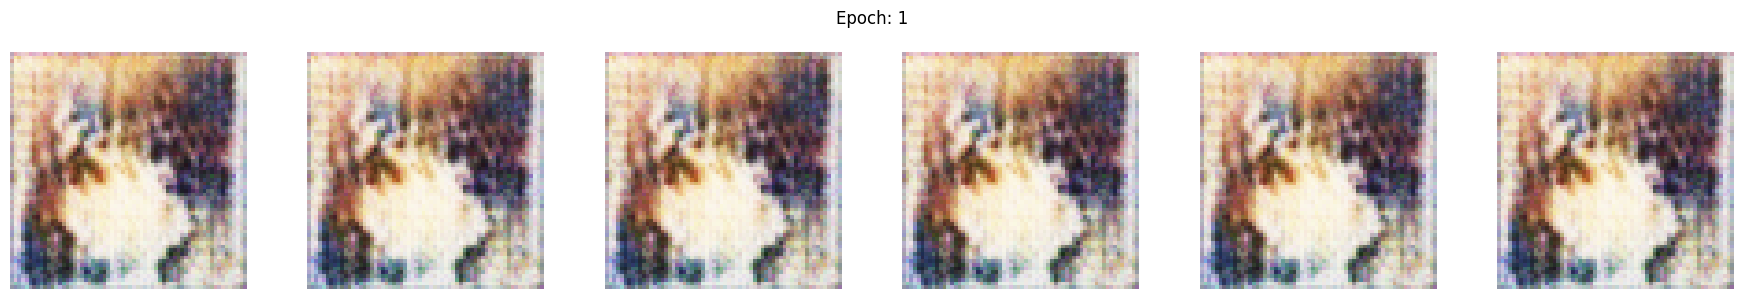

Epoch 2/100 | Avg Critic Loss (W-dist): -45.9592 | Avg Generator Loss: 64.6109


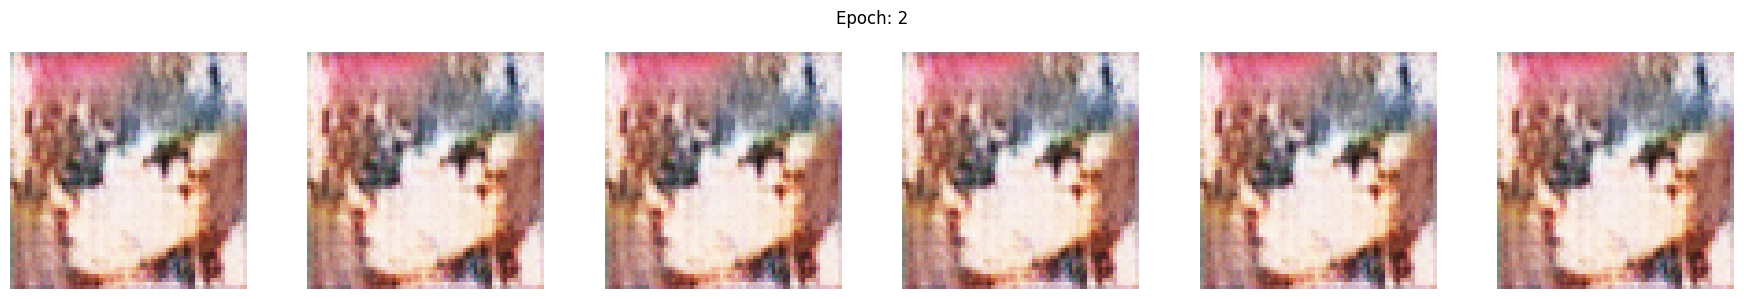

Epoch 3/100 | Avg Critic Loss (W-dist): -35.3215 | Avg Generator Loss: 100.6022


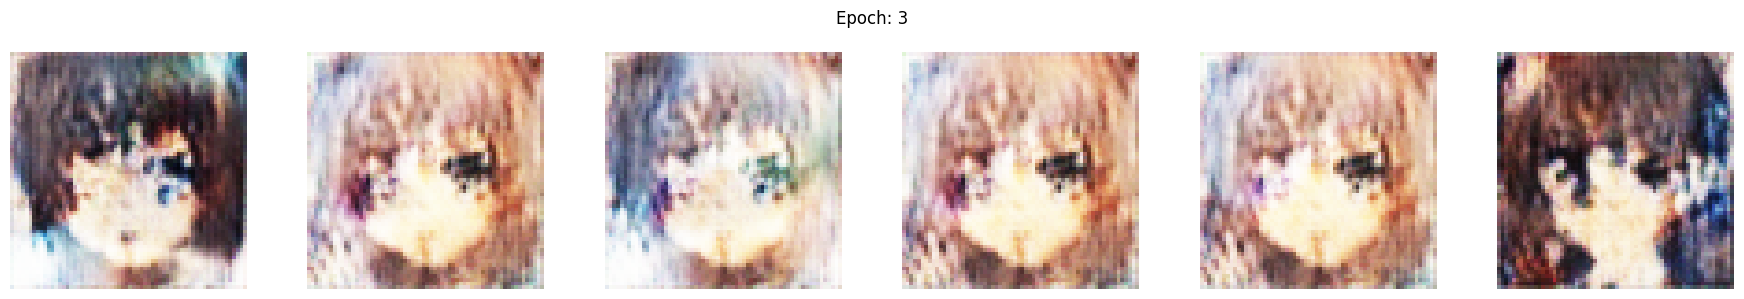

Epoch 4/100 | Avg Critic Loss (W-dist): -18.5830 | Avg Generator Loss: 86.7896


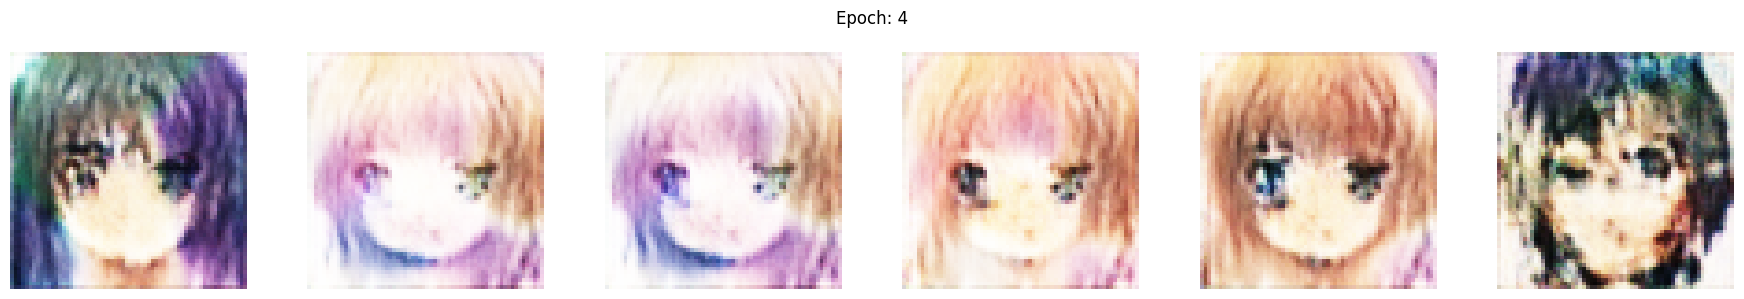

Epoch 5/100 | Avg Critic Loss (W-dist): -14.6578 | Avg Generator Loss: 34.9619


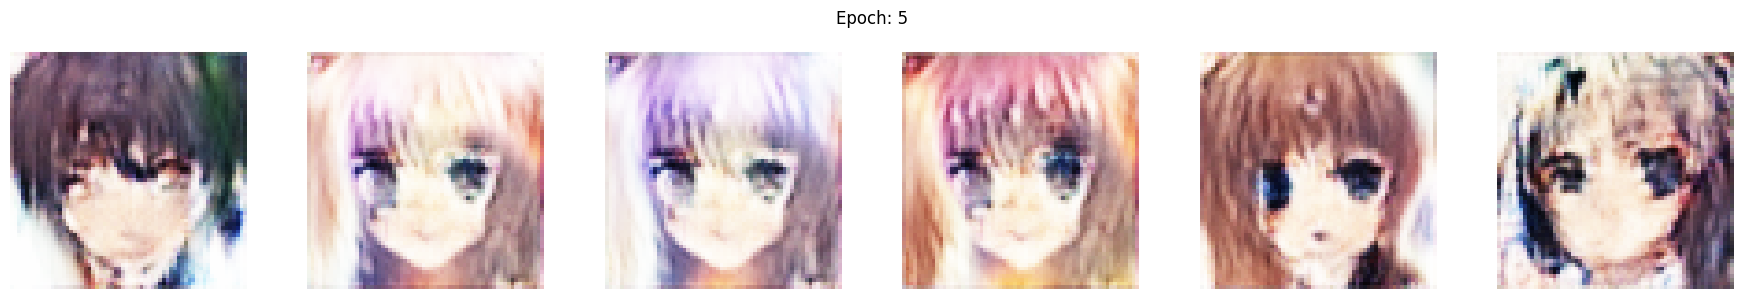

Epoch 6/100 | Avg Critic Loss (W-dist): -11.3852 | Avg Generator Loss: 5.8999


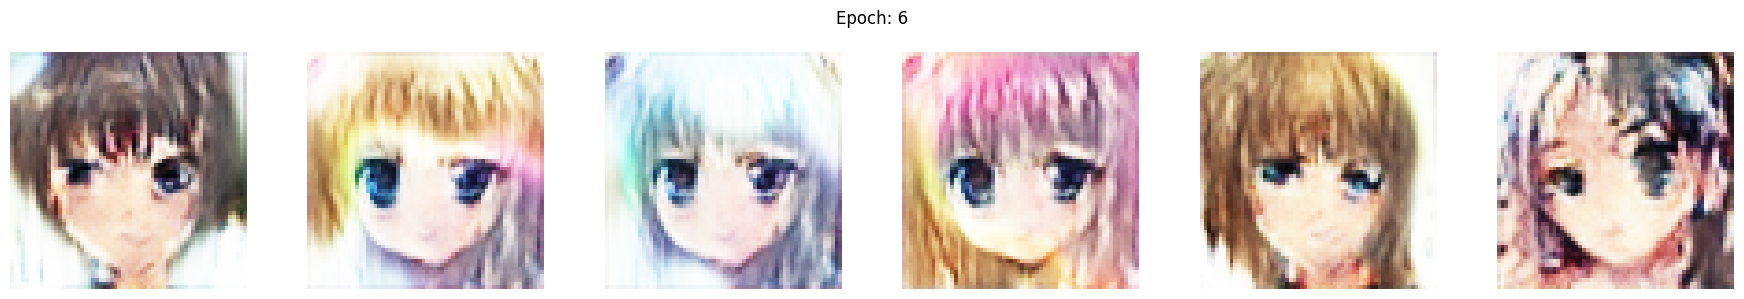

Epoch 7/100 | Avg Critic Loss (W-dist): -10.0003 | Avg Generator Loss: 3.9289


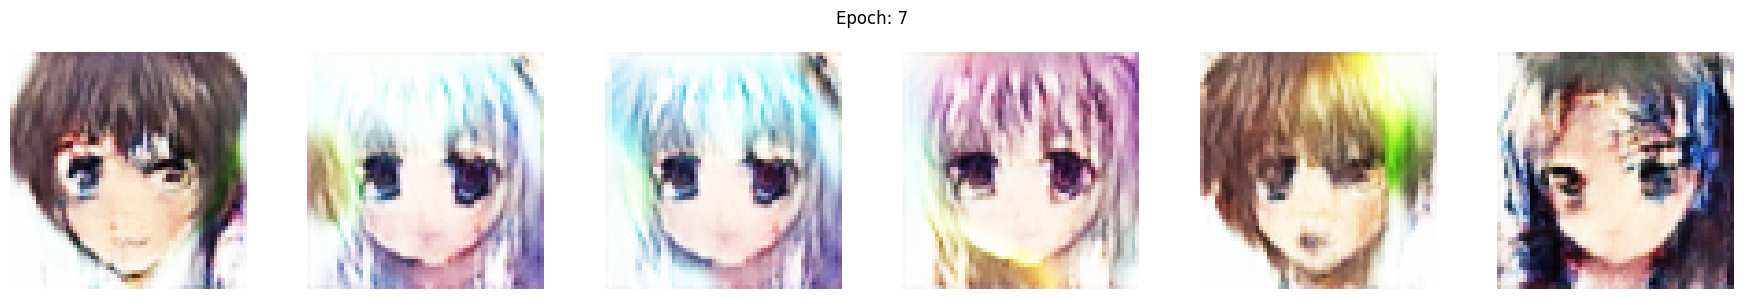

Epoch 8/100 | Avg Critic Loss (W-dist): -9.4868 | Avg Generator Loss: 0.4589


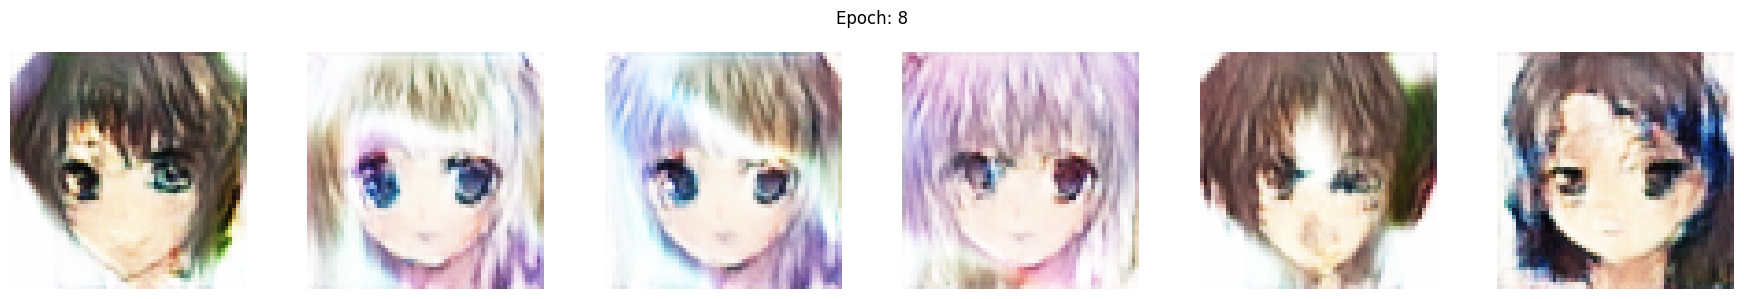

Epoch 9/100 | Avg Critic Loss (W-dist): -9.1772 | Avg Generator Loss: -3.2264


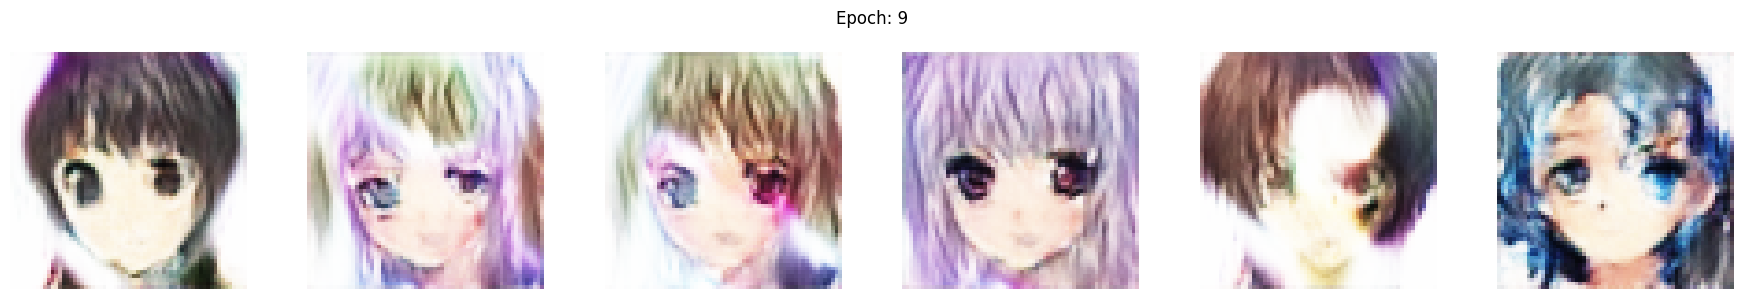

Epoch 10/100 | Avg Critic Loss (W-dist): -8.5821 | Avg Generator Loss: -8.1747


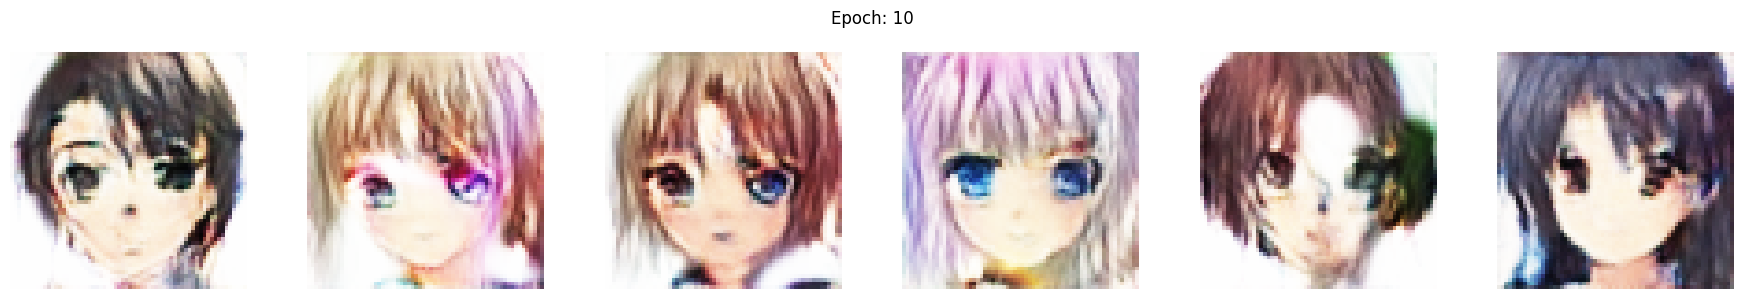

Epoch 11/100 | Avg Critic Loss (W-dist): -8.2308 | Avg Generator Loss: -3.3657


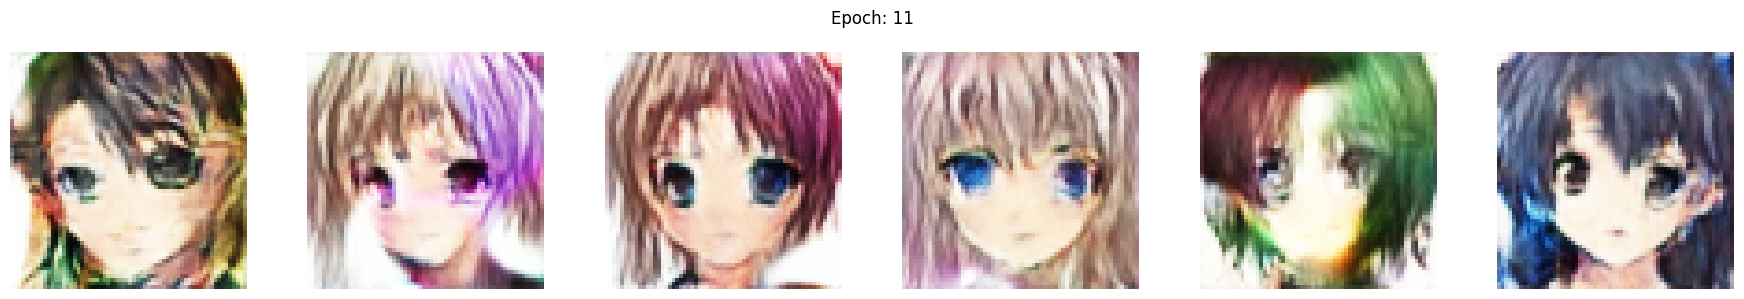

Epoch 12/100 | Avg Critic Loss (W-dist): -7.9826 | Avg Generator Loss: -4.8573


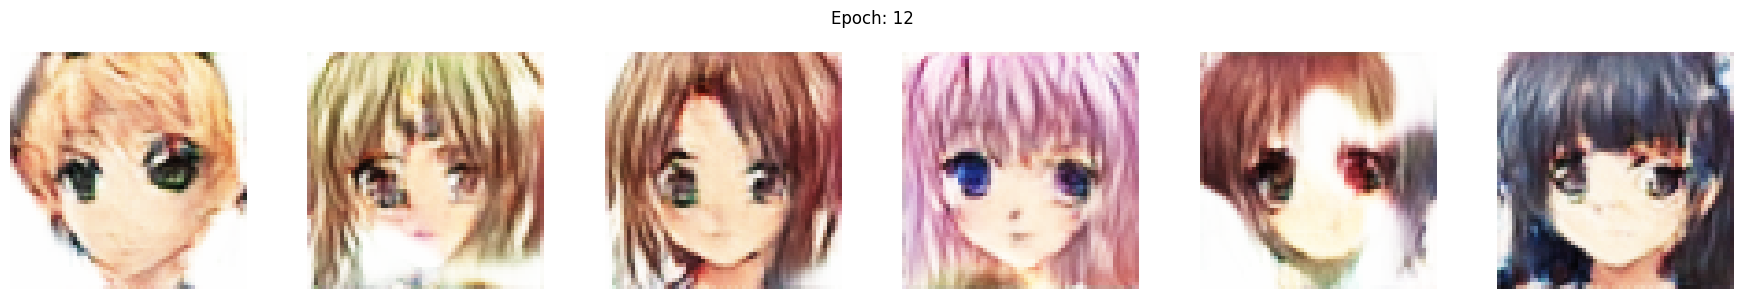

Epoch 13/100 | Avg Critic Loss (W-dist): -7.7372 | Avg Generator Loss: -8.8790


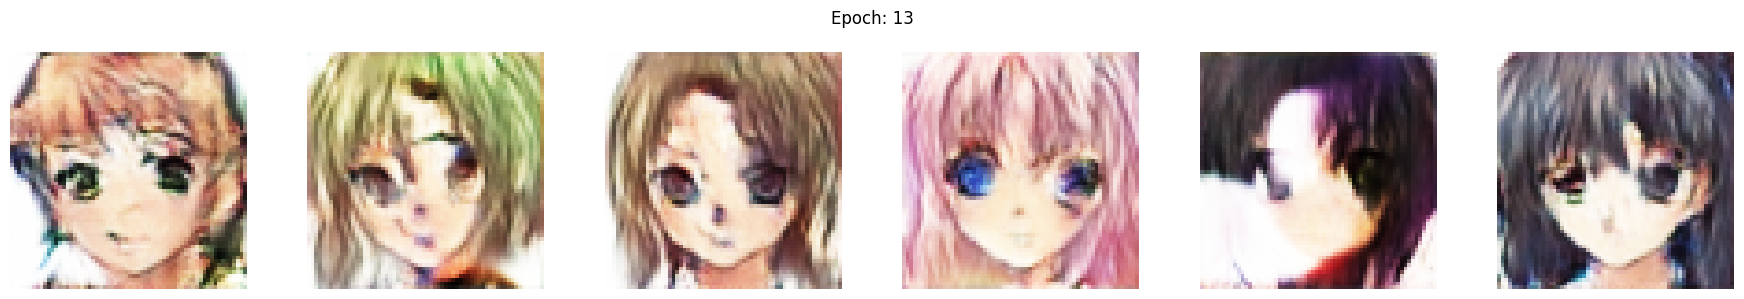

Epoch 14/100 | Avg Critic Loss (W-dist): -7.5349 | Avg Generator Loss: 1.6312


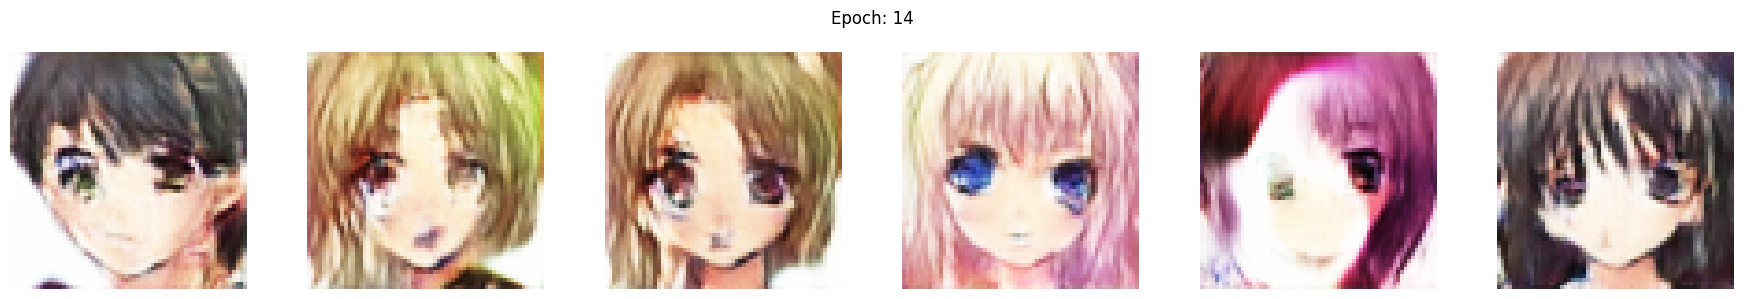

Epoch 15/100 | Avg Critic Loss (W-dist): -7.4925 | Avg Generator Loss: 0.0933


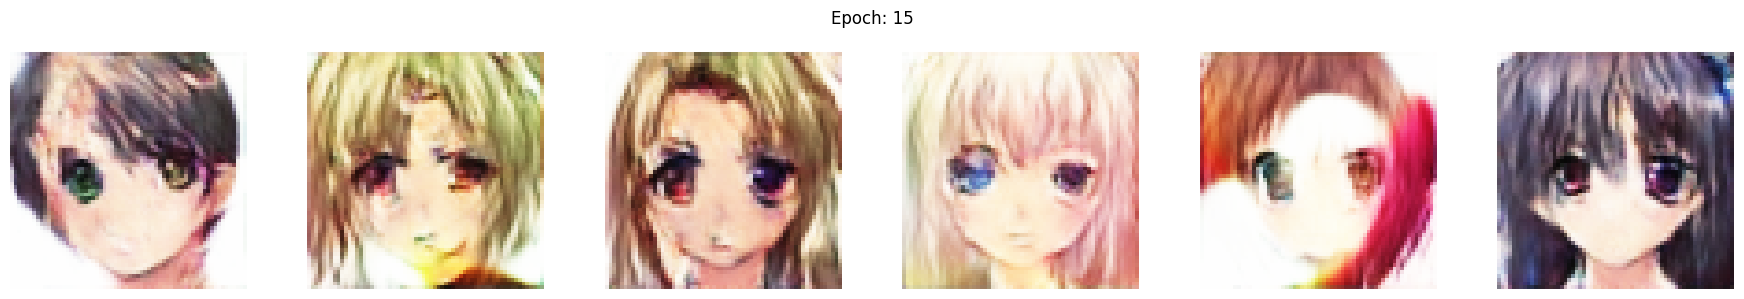

Epoch 16/100 | Avg Critic Loss (W-dist): -7.2250 | Avg Generator Loss: 2.1439


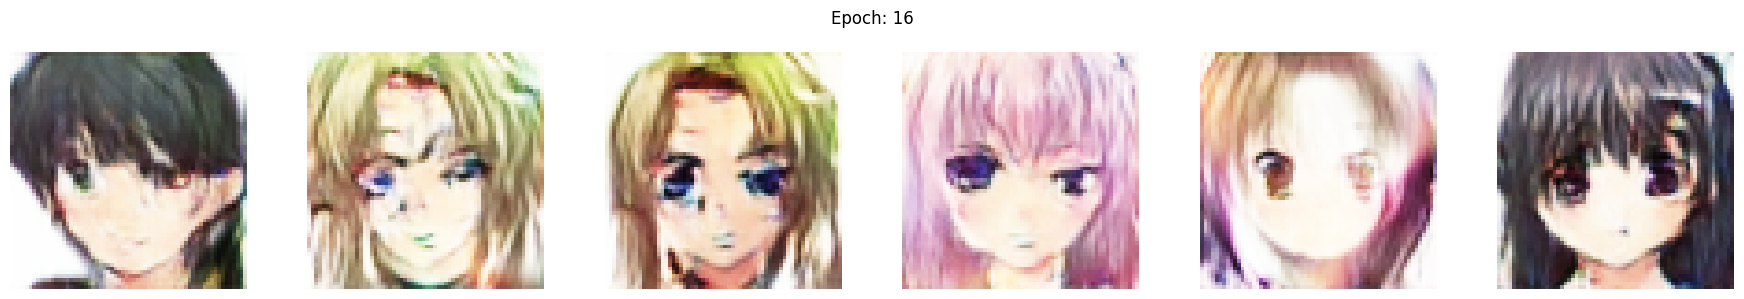

Epoch 17/100 | Avg Critic Loss (W-dist): -7.2432 | Avg Generator Loss: 9.2923


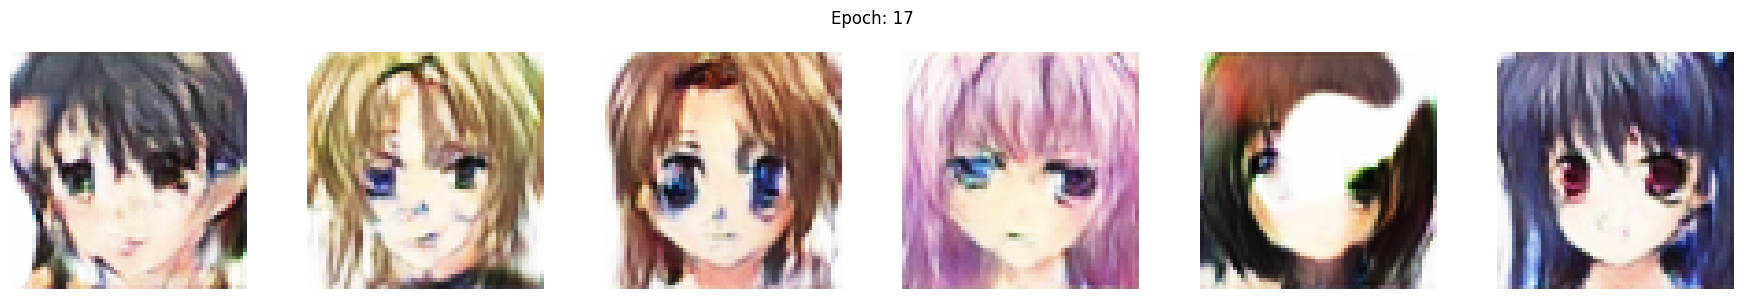

Epoch 18/100 | Avg Critic Loss (W-dist): -7.0067 | Avg Generator Loss: 3.5816


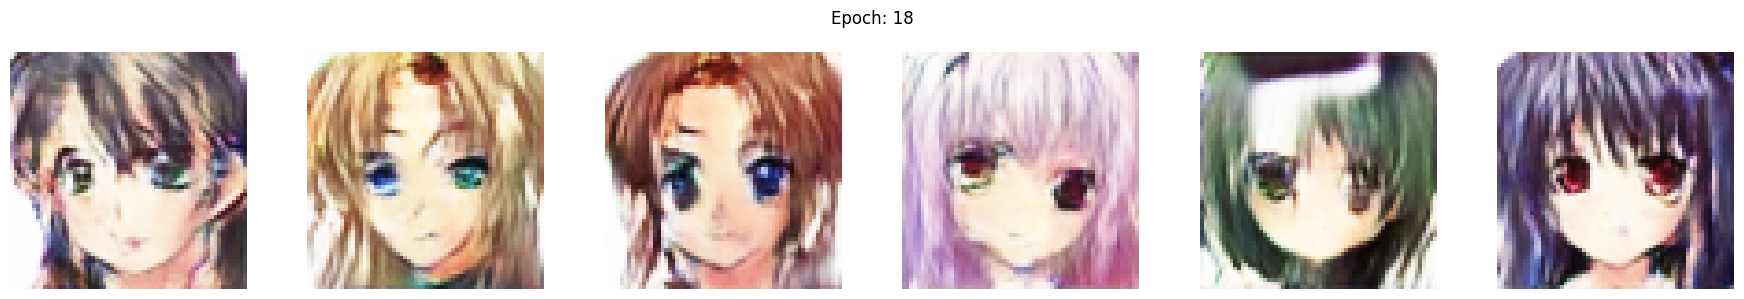

Epoch 19/100 | Avg Critic Loss (W-dist): -6.9361 | Avg Generator Loss: -2.1973


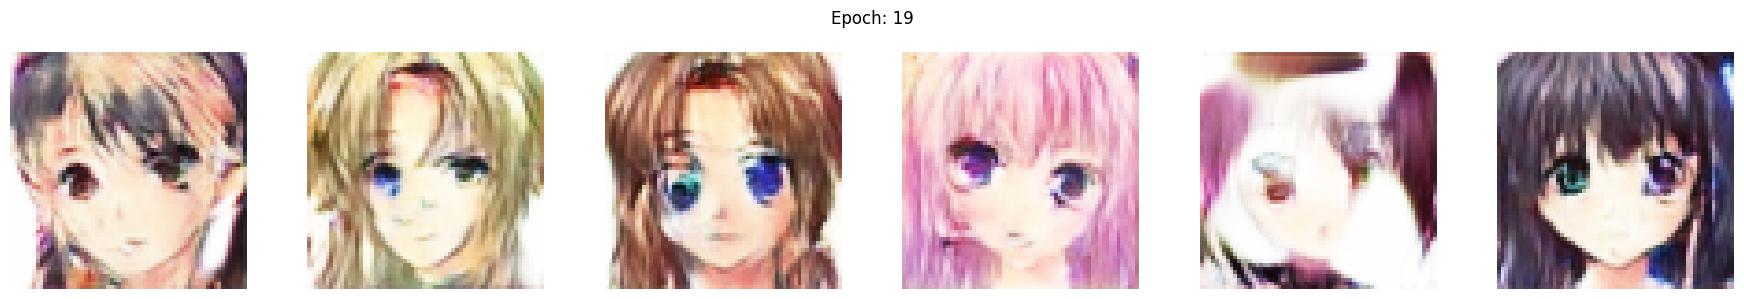

Epoch 20/100 | Avg Critic Loss (W-dist): -6.0262 | Avg Generator Loss: 0.2891


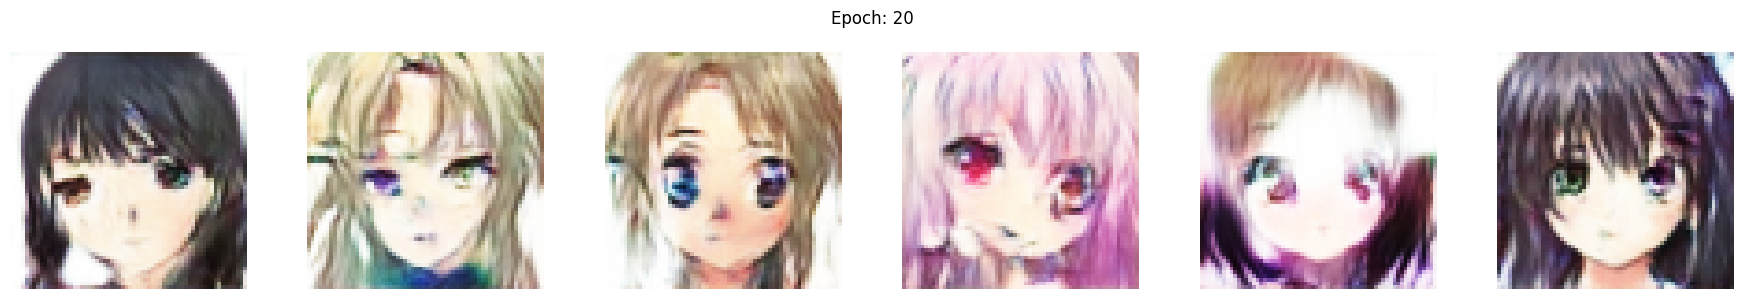

Epoch 21/100 | Avg Critic Loss (W-dist): -5.6952 | Avg Generator Loss: 9.6807


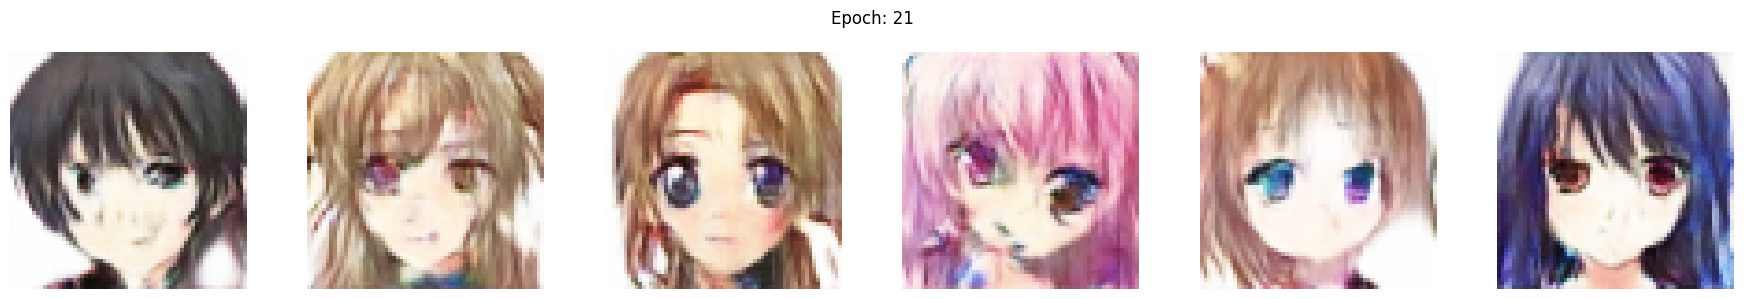

Epoch 22/100 | Avg Critic Loss (W-dist): -5.5363 | Avg Generator Loss: 7.6924


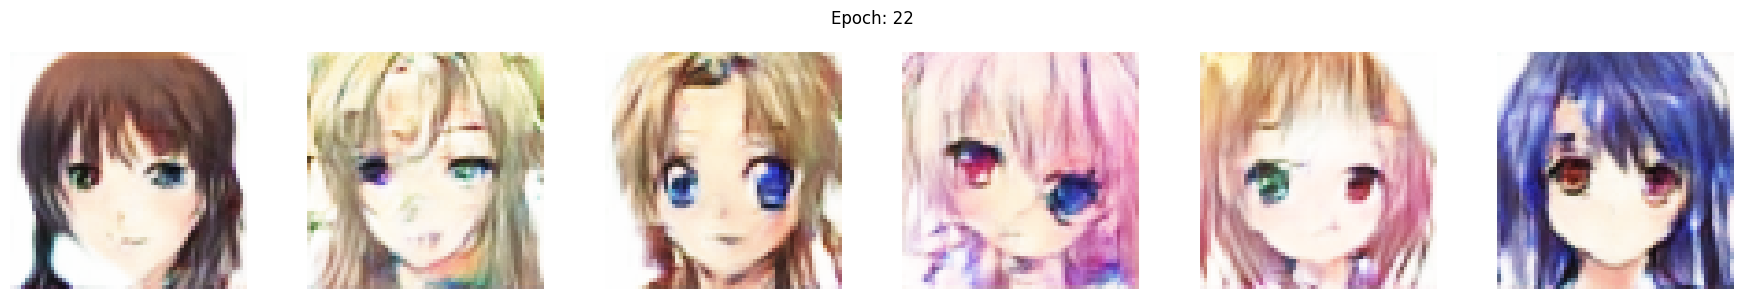

Epoch 23/100 | Avg Critic Loss (W-dist): -5.4864 | Avg Generator Loss: 10.4253


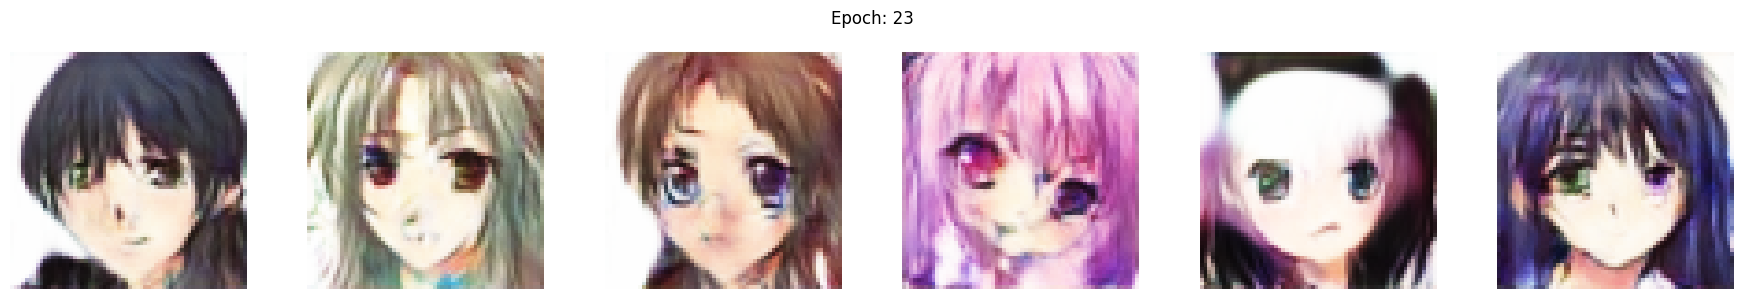

Epoch 24/100 | Avg Critic Loss (W-dist): -5.3987 | Avg Generator Loss: 14.2498


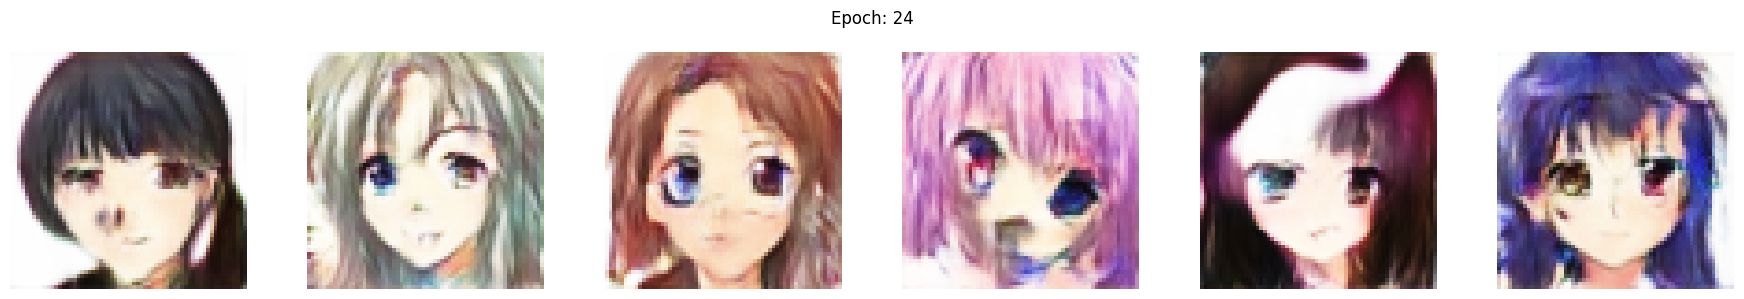

Epoch 25/100 | Avg Critic Loss (W-dist): -5.3832 | Avg Generator Loss: 13.0609


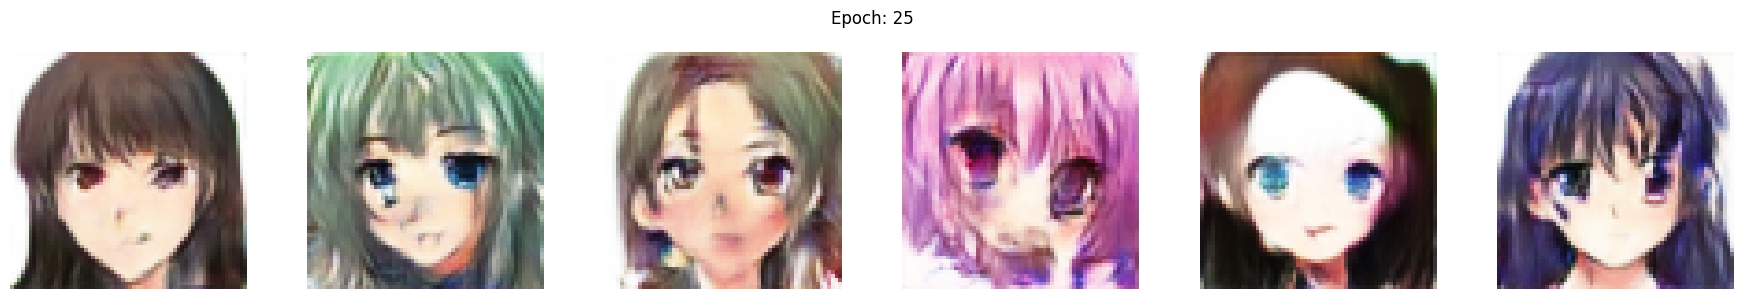

Epoch 26/100 | Avg Critic Loss (W-dist): -5.2570 | Avg Generator Loss: 5.9572


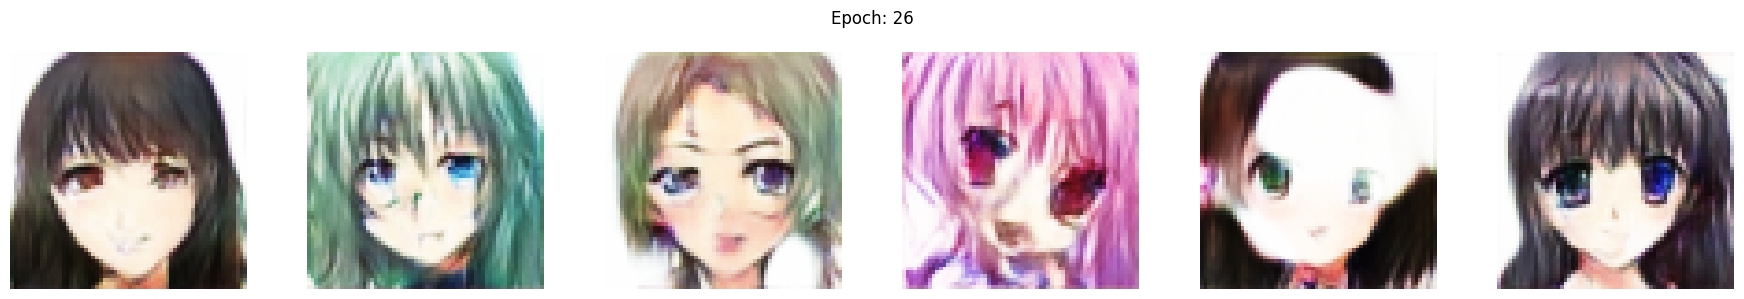

Epoch 27/100 | Avg Critic Loss (W-dist): -5.1836 | Avg Generator Loss: 10.9591


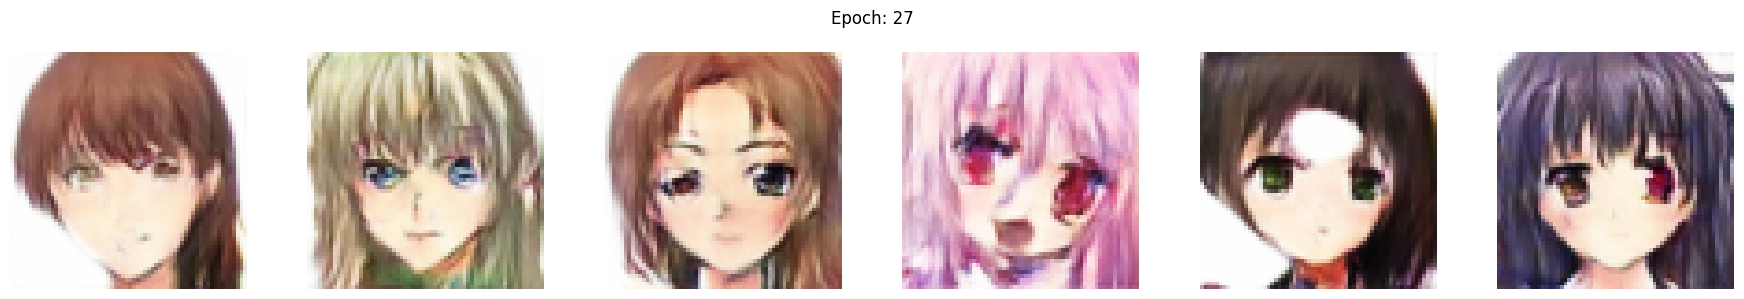

Epoch 28/100 | Avg Critic Loss (W-dist): -5.1461 | Avg Generator Loss: 15.4565


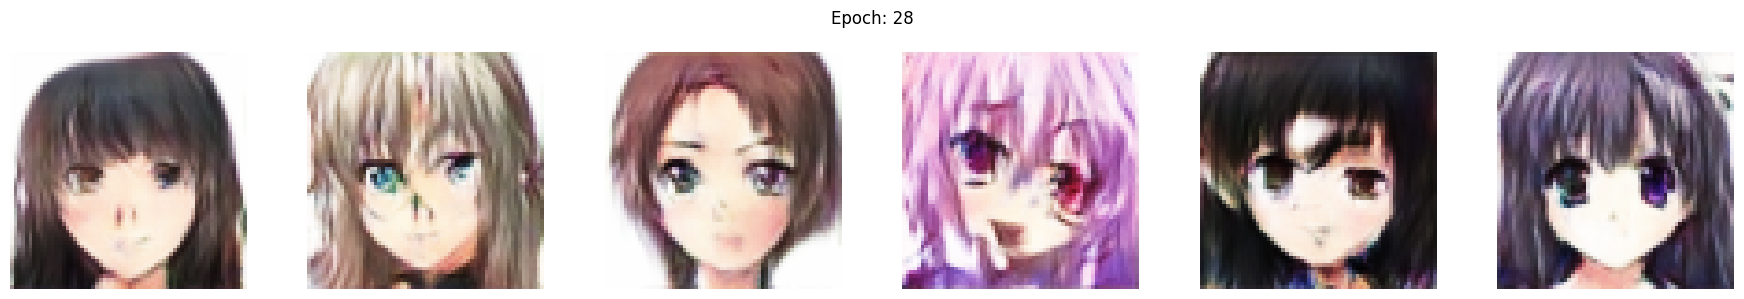

Epoch 29/100 | Avg Critic Loss (W-dist): -5.1165 | Avg Generator Loss: 25.4039


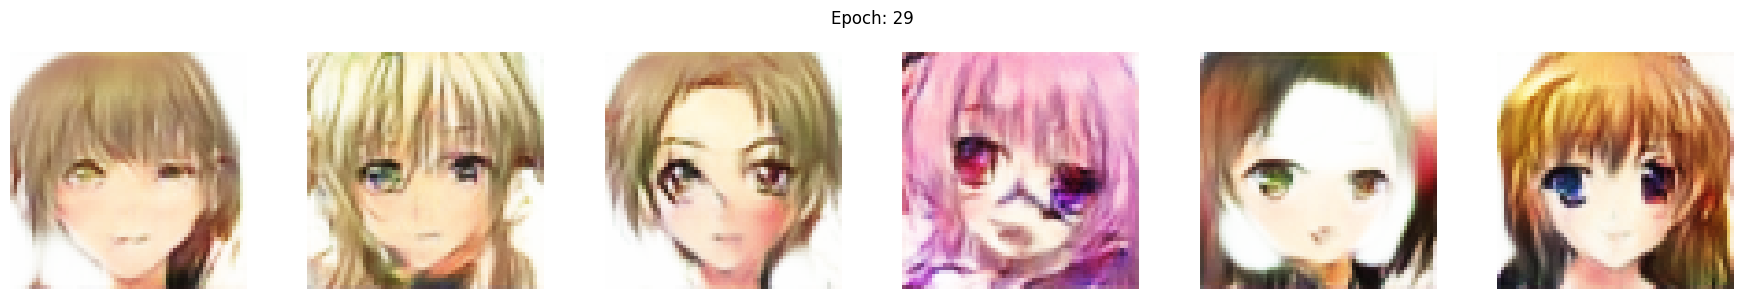

Epoch 30/100 | Avg Critic Loss (W-dist): -4.1126 | Avg Generator Loss: 20.4311


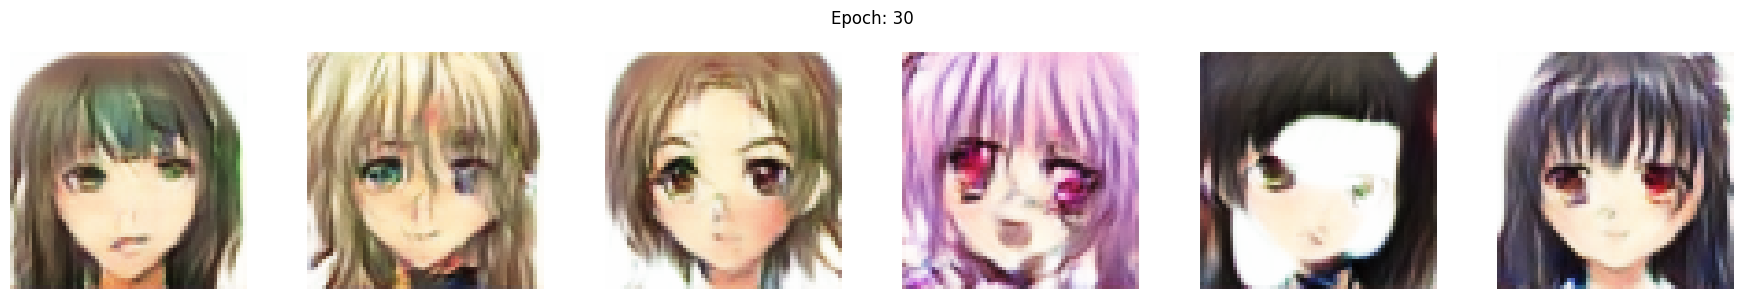

Epoch 31/100 | Avg Critic Loss (W-dist): -3.9398 | Avg Generator Loss: 23.8075


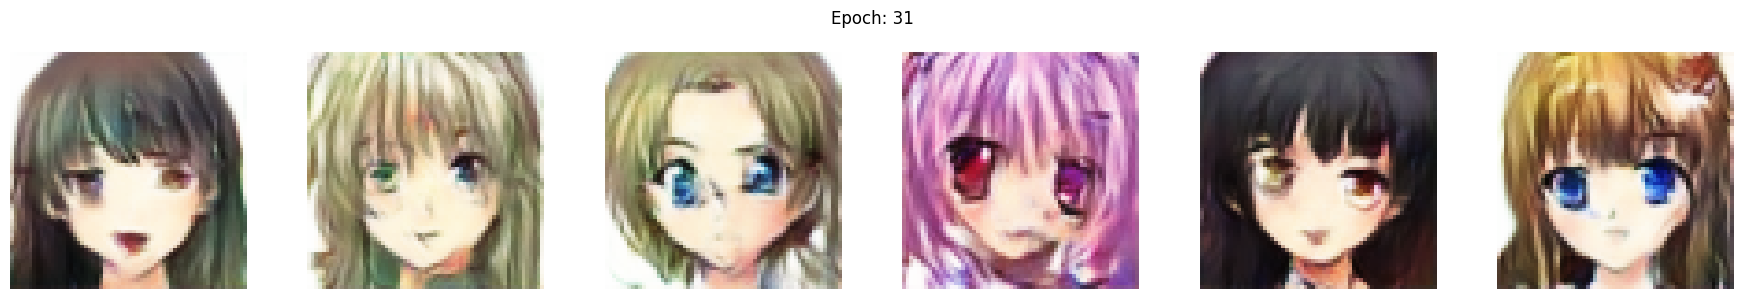

Epoch 32/100 | Avg Critic Loss (W-dist): -3.8322 | Avg Generator Loss: 21.1705


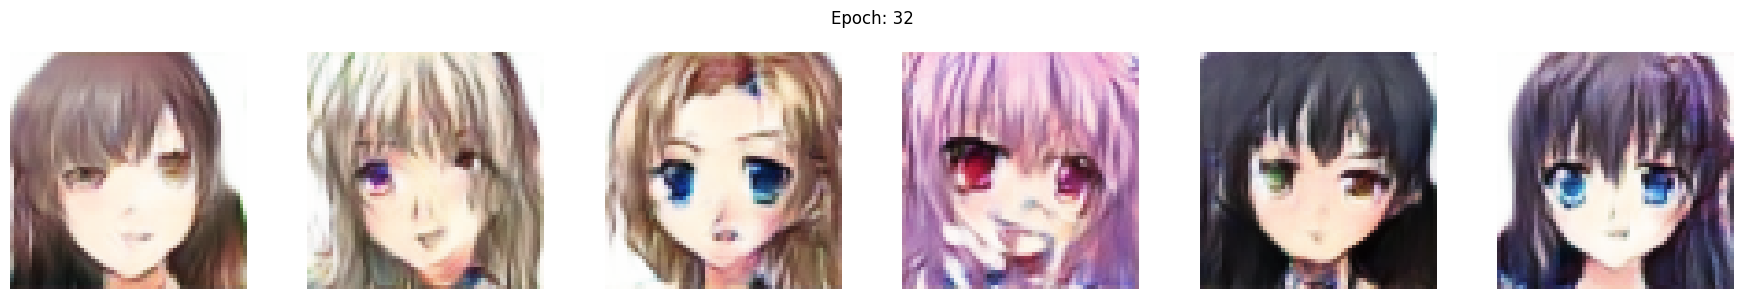

Epoch 33/100 | Avg Critic Loss (W-dist): -3.7256 | Avg Generator Loss: 24.9965


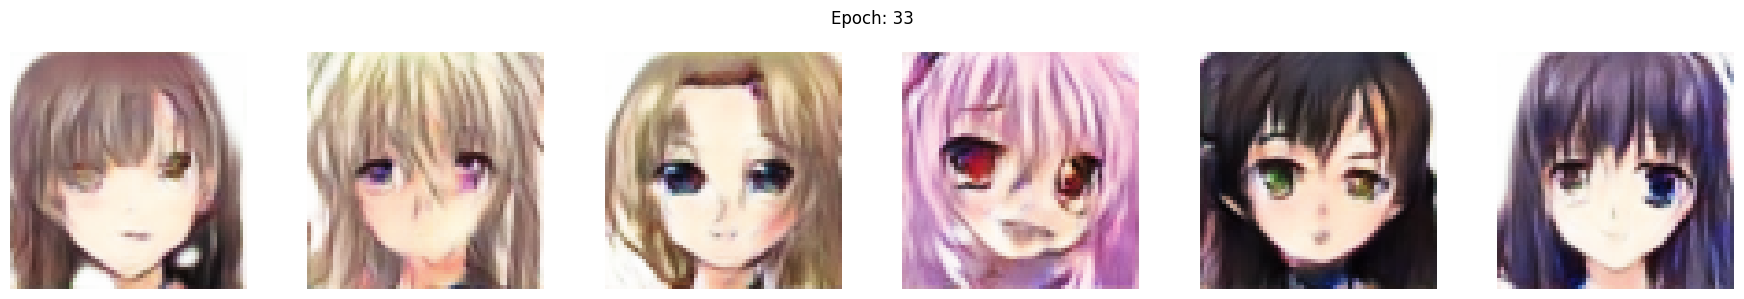

Epoch 34/100 | Avg Critic Loss (W-dist): -3.7465 | Avg Generator Loss: 20.4632


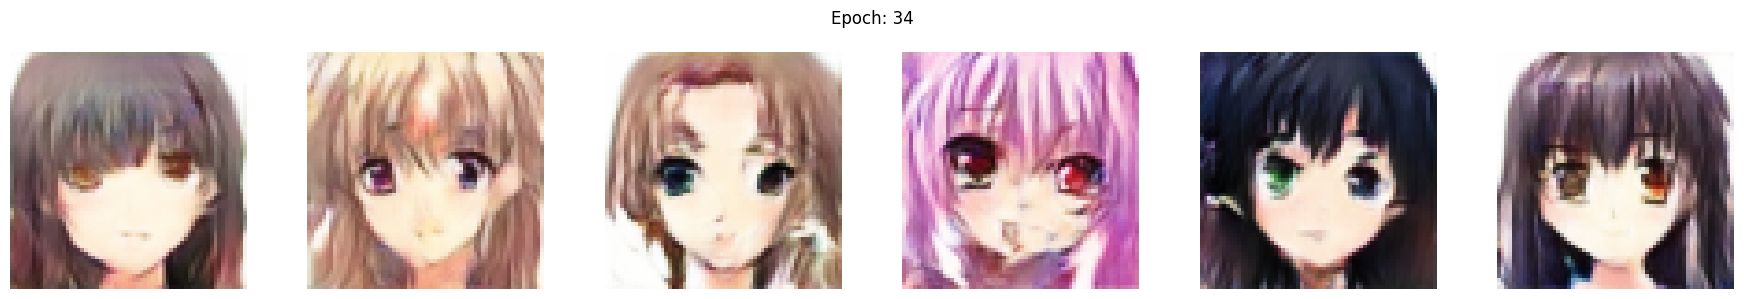

Epoch 35/100 | Avg Critic Loss (W-dist): -3.6497 | Avg Generator Loss: 23.4824


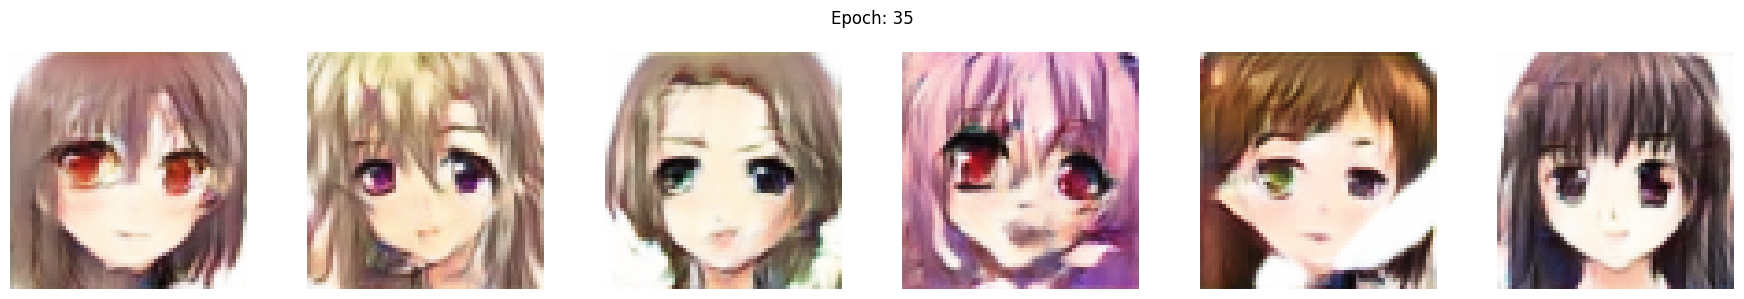

Epoch 36/100 | Avg Critic Loss (W-dist): -3.6311 | Avg Generator Loss: 23.8308


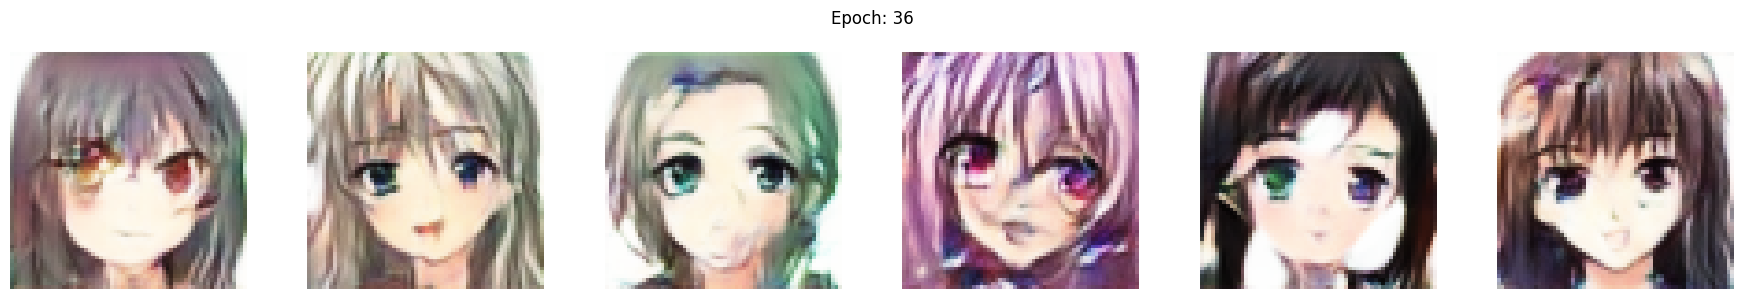

Epoch 37/100 | Avg Critic Loss (W-dist): -3.5959 | Avg Generator Loss: 24.4101


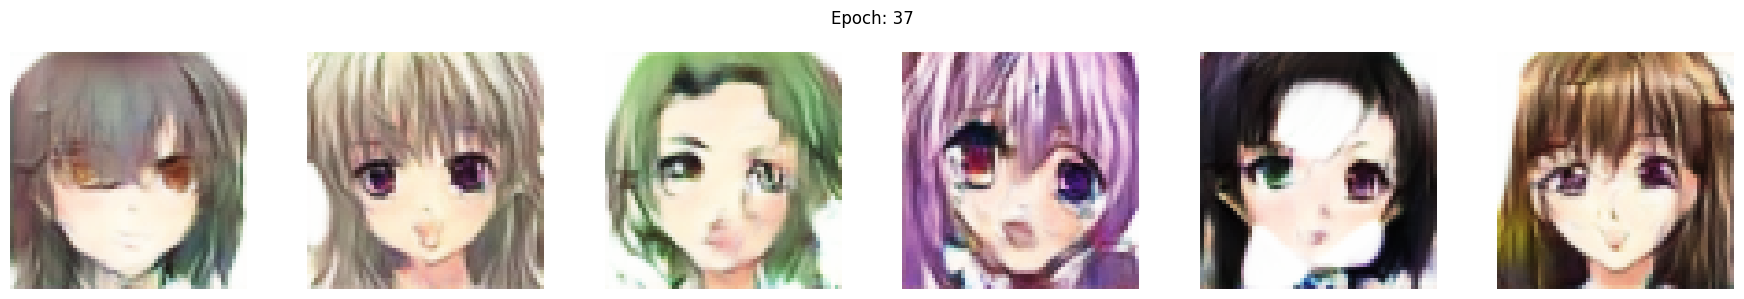

Epoch 38/100 | Avg Critic Loss (W-dist): -3.5429 | Avg Generator Loss: 23.9337


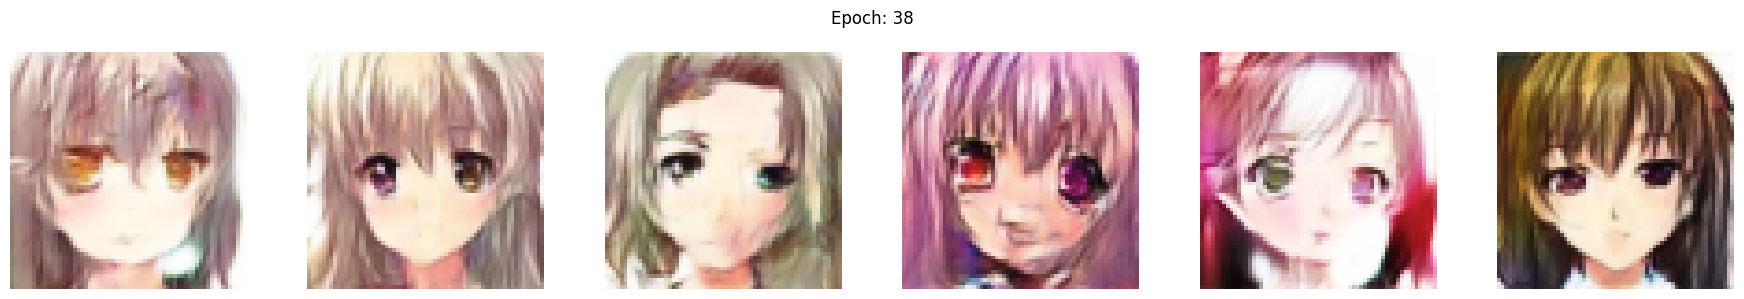

Epoch 39/100 | Avg Critic Loss (W-dist): -3.4988 | Avg Generator Loss: 25.6191


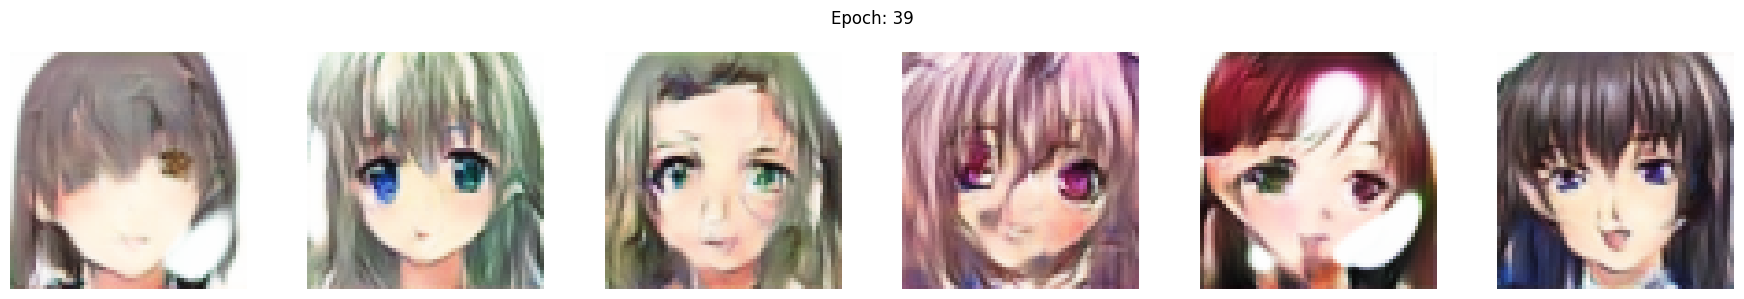

Epoch 40/100 | Avg Critic Loss (W-dist): -3.5031 | Avg Generator Loss: 25.3569


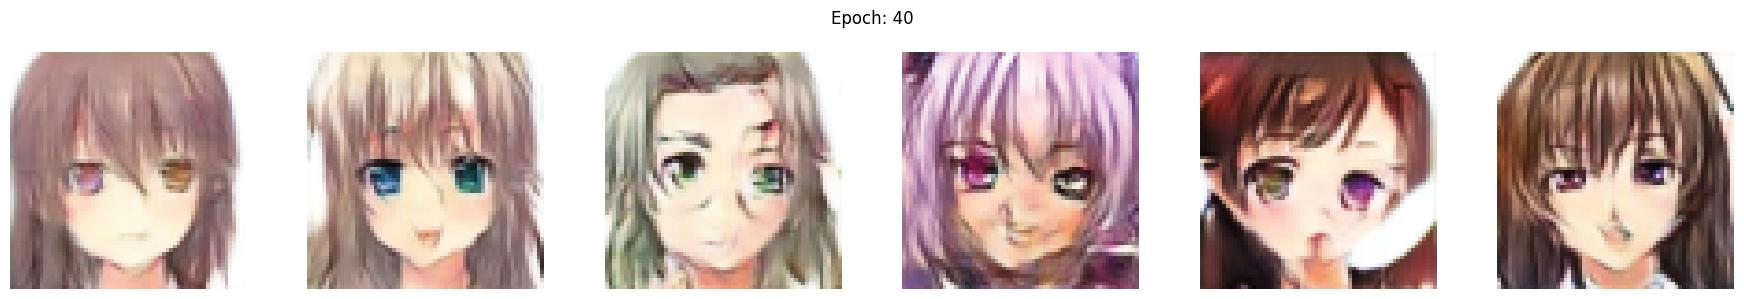

Epoch 41/100 | Avg Critic Loss (W-dist): -3.4028 | Avg Generator Loss: 27.2357


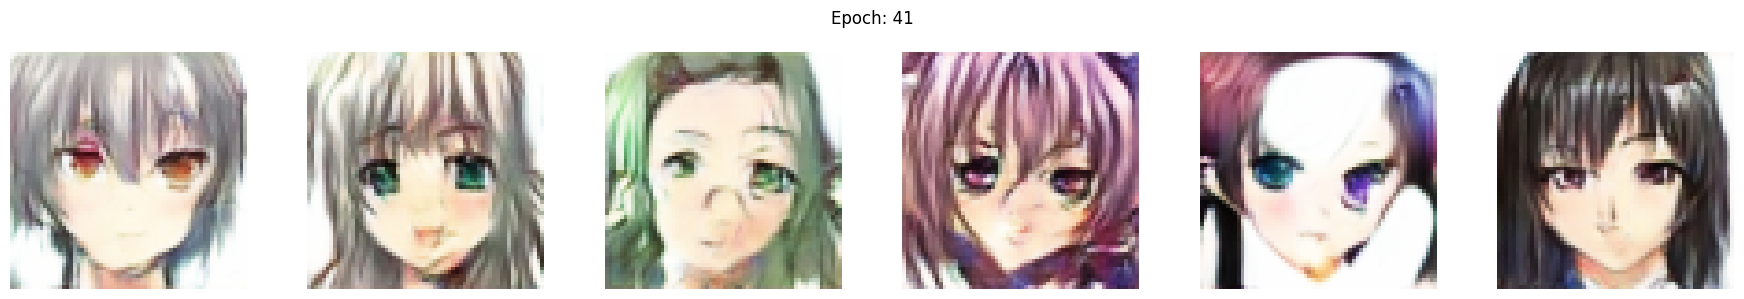

Epoch 42/100 | Avg Critic Loss (W-dist): -3.3833 | Avg Generator Loss: 25.4513


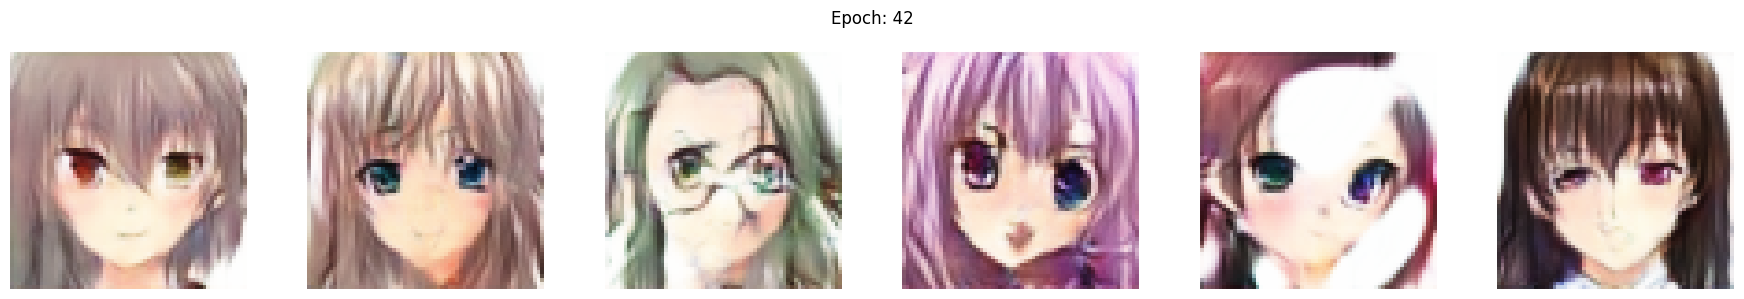

Epoch 43/100 | Avg Critic Loss (W-dist): -3.3891 | Avg Generator Loss: 25.5721


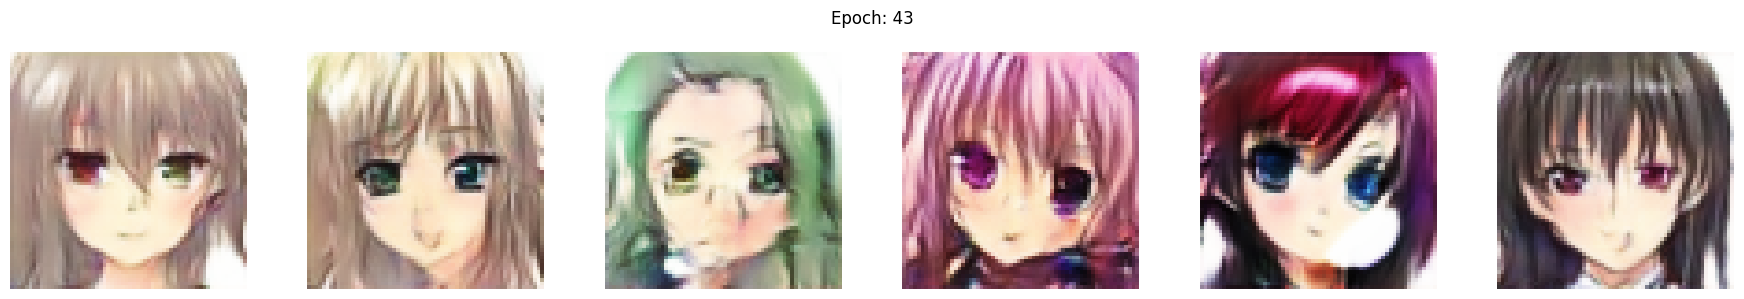

Epoch 44/100 | Avg Critic Loss (W-dist): -3.3527 | Avg Generator Loss: 24.6832


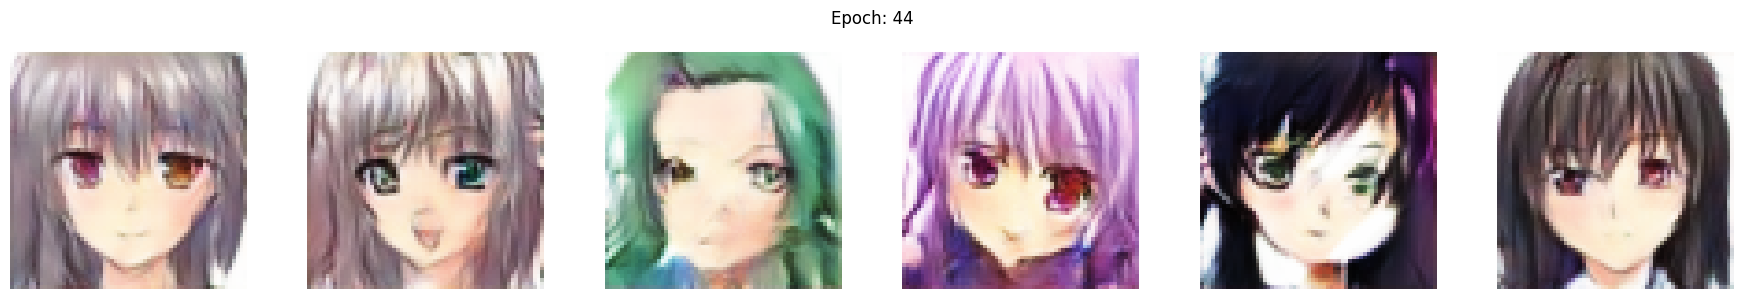

Epoch 45/100 | Avg Critic Loss (W-dist): -3.3626 | Avg Generator Loss: 26.5433


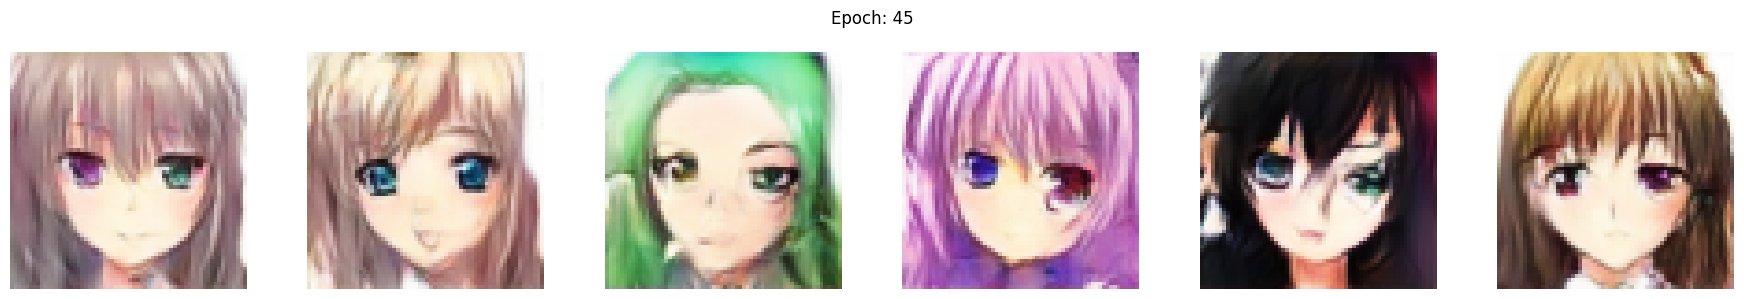

Epoch 46/100 | Avg Critic Loss (W-dist): -3.3575 | Avg Generator Loss: 25.9291


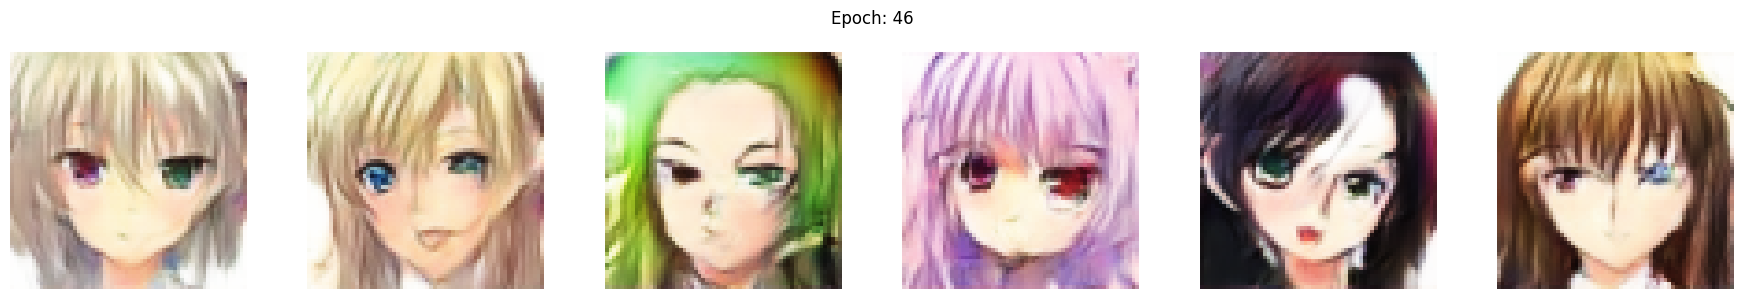

Epoch 47/100 | Avg Critic Loss (W-dist): -3.2811 | Avg Generator Loss: 22.8460


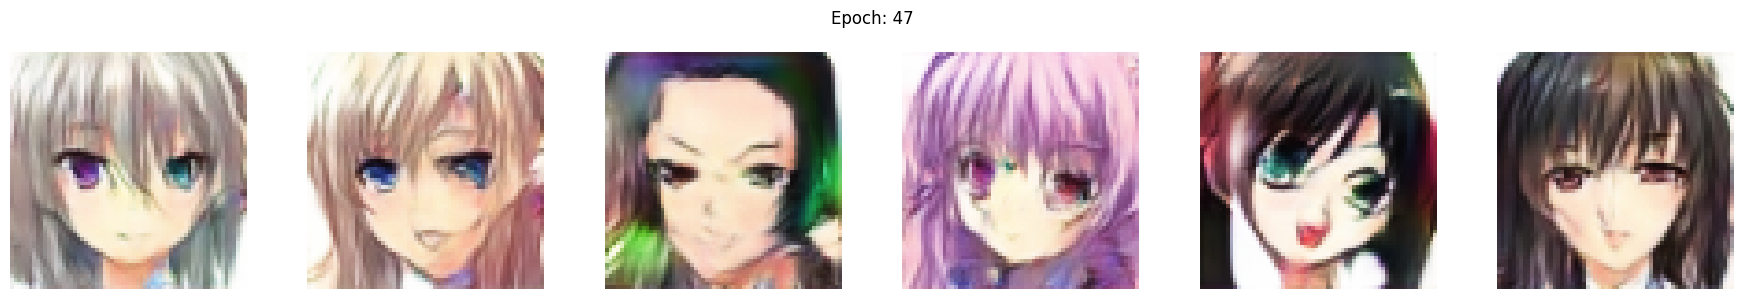

Epoch 48/100 | Avg Critic Loss (W-dist): -3.2876 | Avg Generator Loss: 20.9105


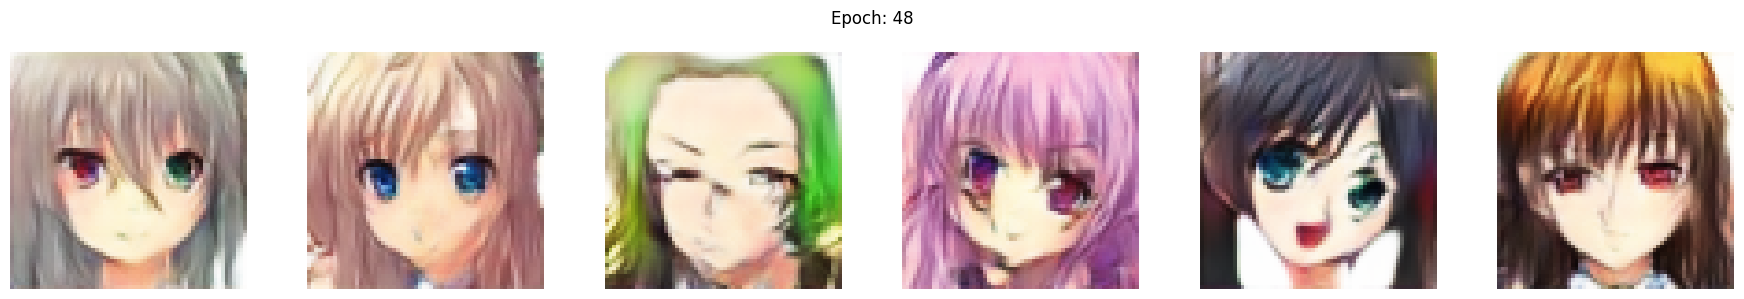

Epoch 49/100 | Avg Critic Loss (W-dist): -3.2845 | Avg Generator Loss: 23.7782


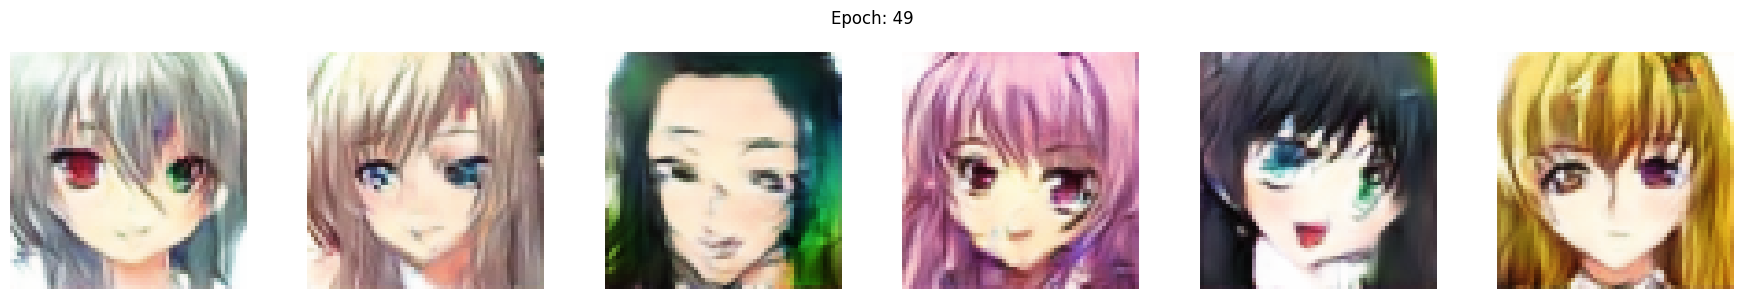

Epoch 50/100 | Avg Critic Loss (W-dist): -3.2758 | Avg Generator Loss: 22.9306


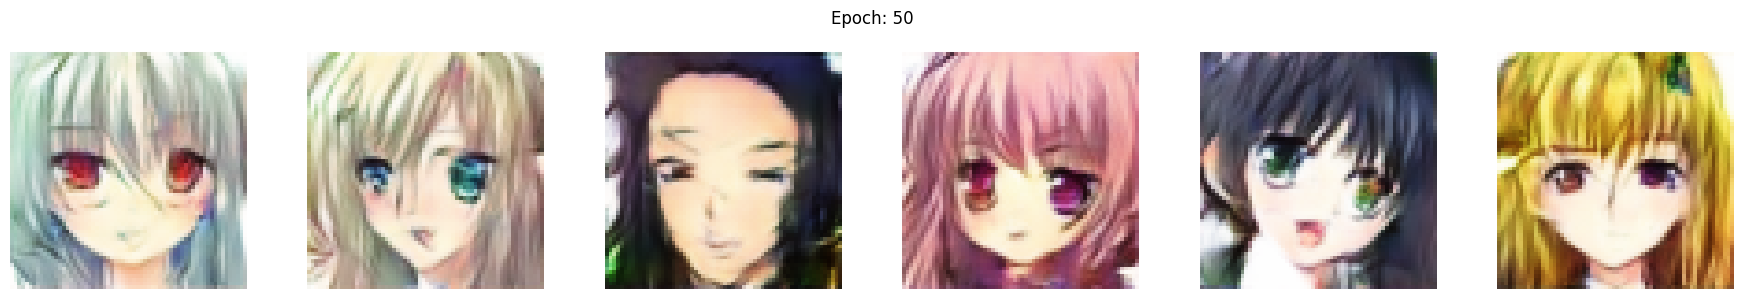

Epoch 51/100 | Avg Critic Loss (W-dist): -3.2490 | Avg Generator Loss: 22.9677


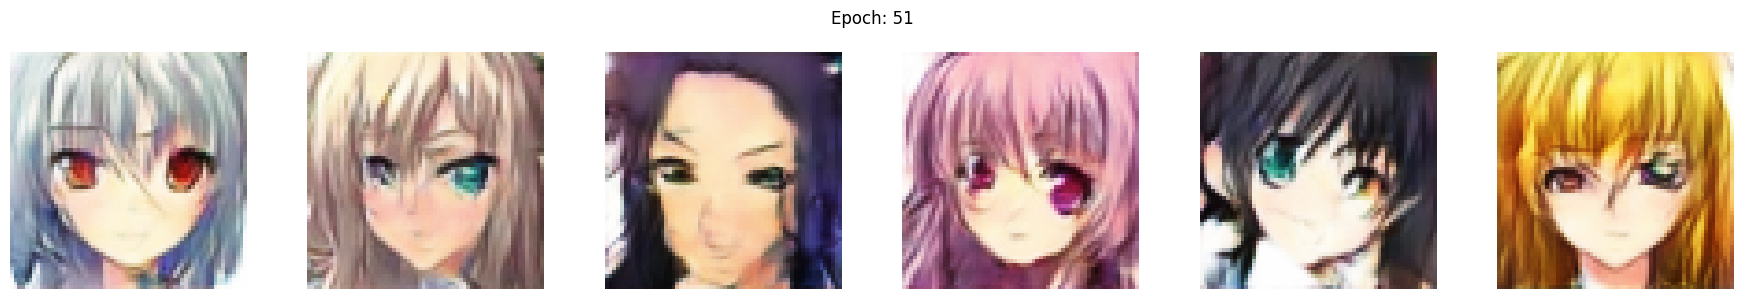

Epoch 52/100 | Avg Critic Loss (W-dist): -3.2787 | Avg Generator Loss: 23.1265


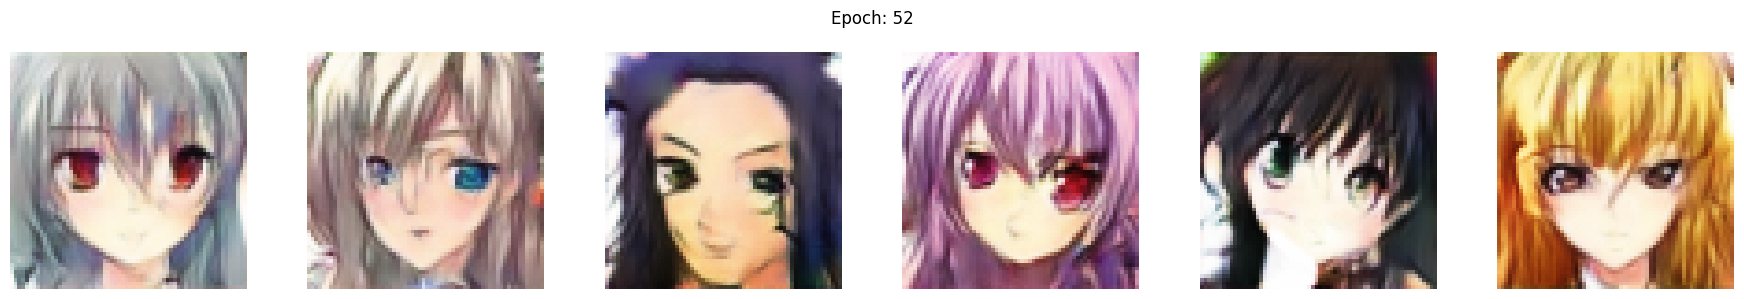

Epoch 53/100 | Avg Critic Loss (W-dist): -3.2431 | Avg Generator Loss: 24.6668


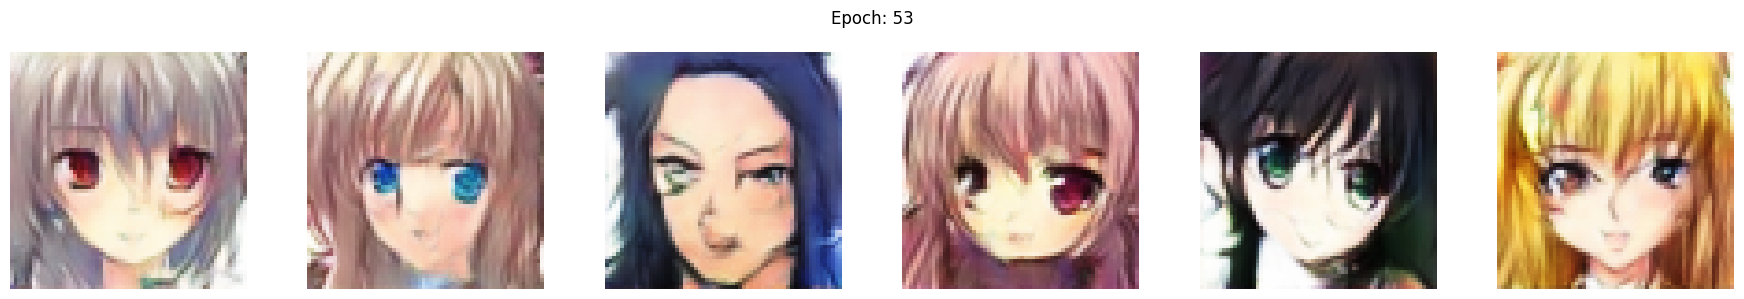

Epoch 54/100 | Avg Critic Loss (W-dist): -3.1819 | Avg Generator Loss: 24.4245


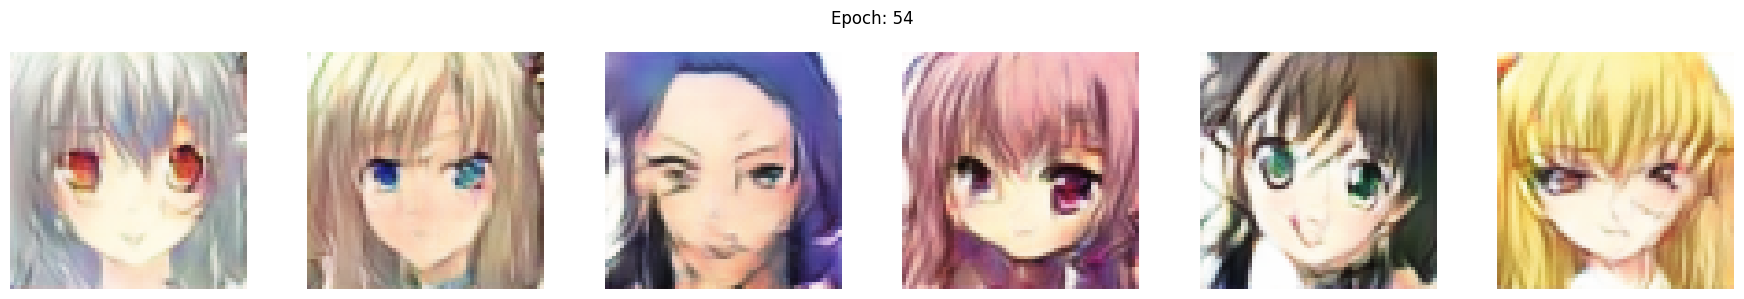

Epoch 55/100 | Avg Critic Loss (W-dist): -3.1640 | Avg Generator Loss: 26.6381


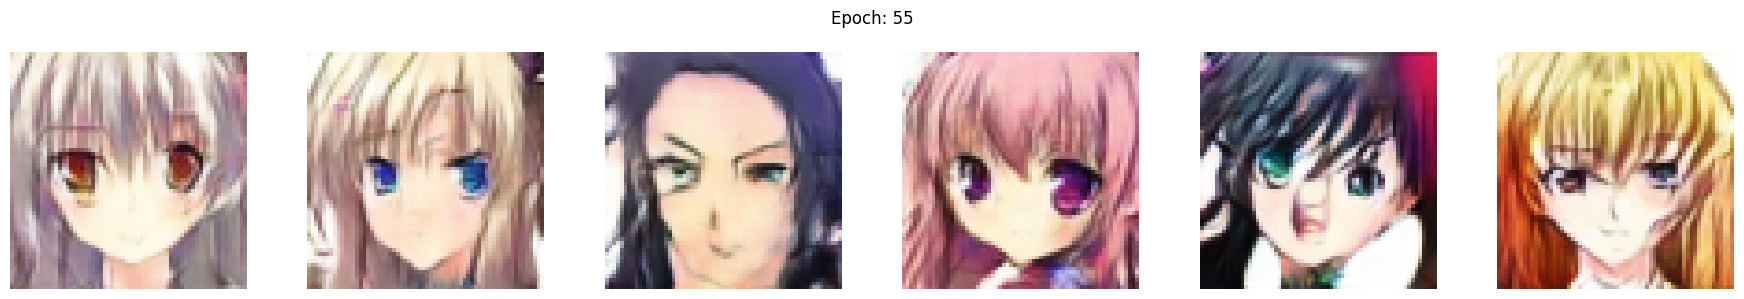

Epoch 56/100 | Avg Critic Loss (W-dist): -3.1594 | Avg Generator Loss: 26.2529


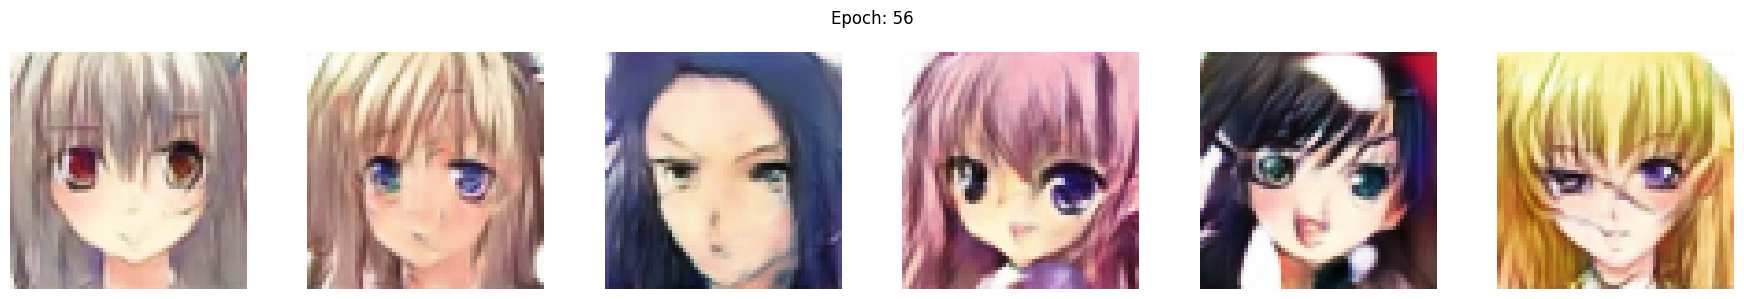

Epoch 57/100 | Avg Critic Loss (W-dist): -3.1087 | Avg Generator Loss: 25.1200


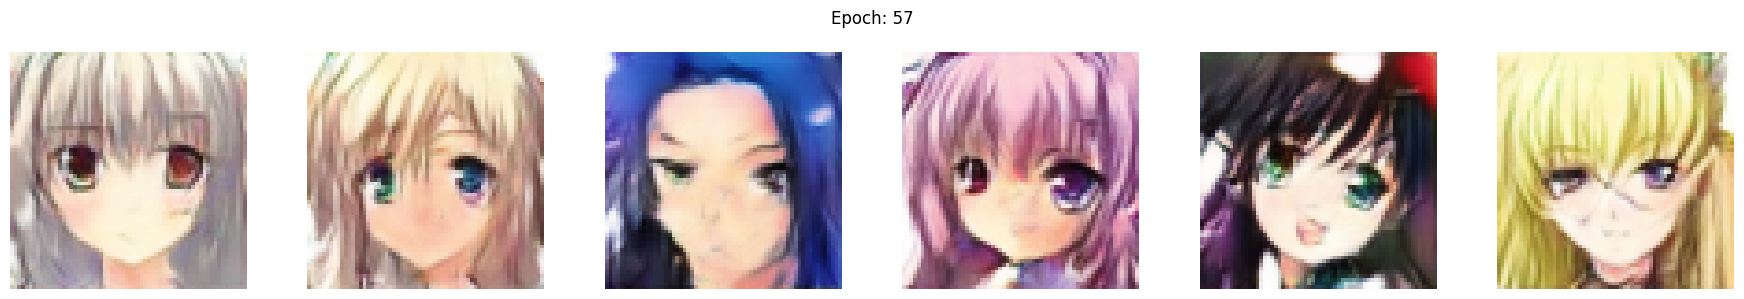

Epoch 58/100 | Avg Critic Loss (W-dist): -3.1250 | Avg Generator Loss: 23.1090


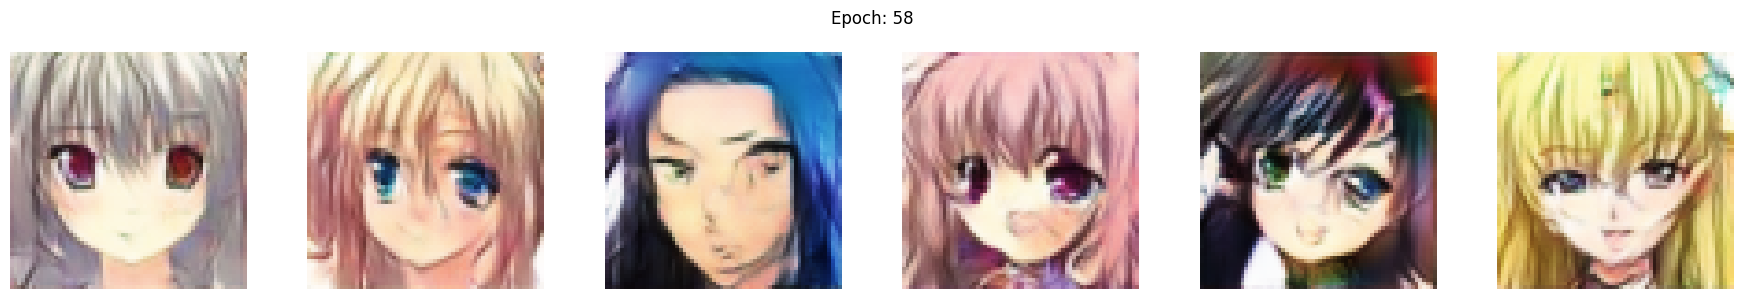

Epoch 59/100 | Avg Critic Loss (W-dist): -3.1004 | Avg Generator Loss: 21.1851


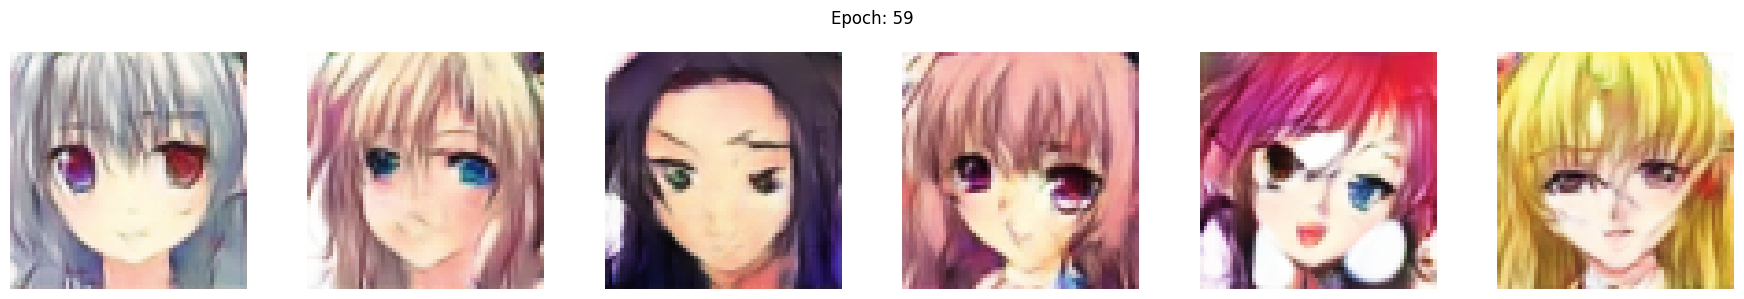

Epoch 60/100 | Avg Critic Loss (W-dist): -3.1127 | Avg Generator Loss: 20.8341


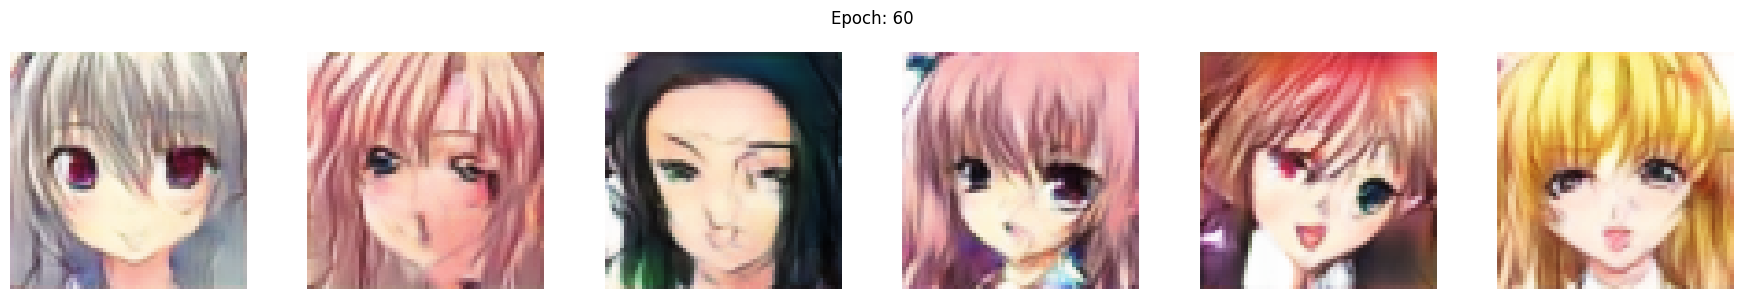

Epoch 61/100 | Avg Critic Loss (W-dist): -3.1259 | Avg Generator Loss: 21.8151


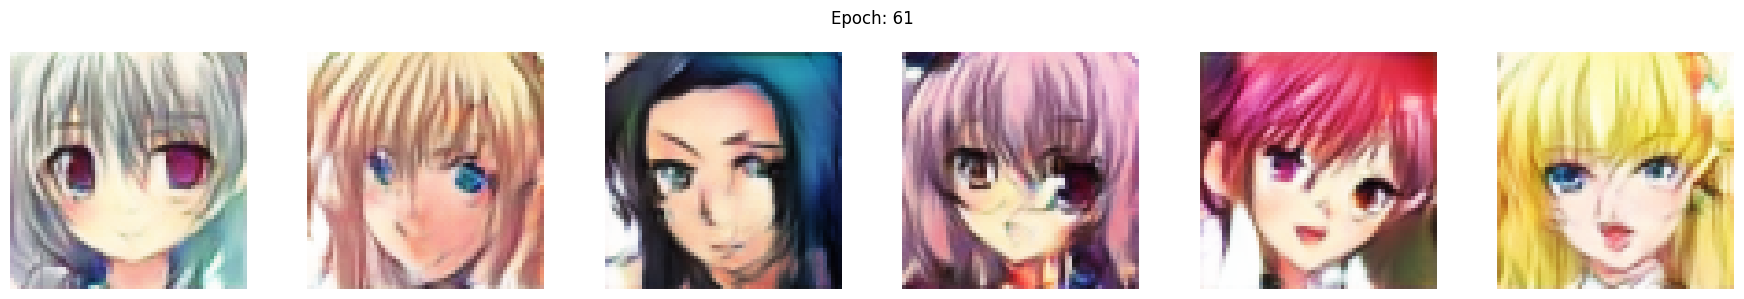

Epoch 62/100 | Avg Critic Loss (W-dist): -3.1090 | Avg Generator Loss: 23.6212


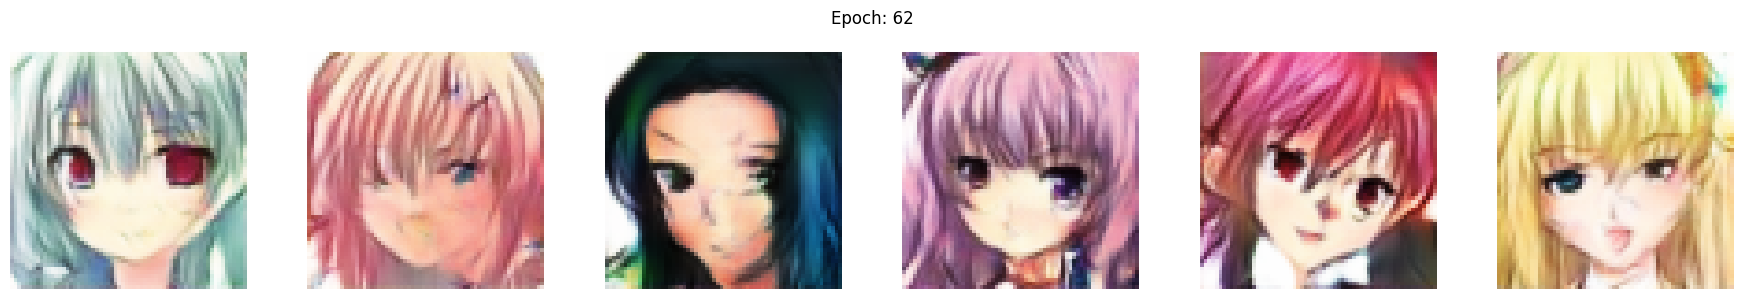

Epoch 63/100 | Avg Critic Loss (W-dist): -3.0755 | Avg Generator Loss: 24.1277


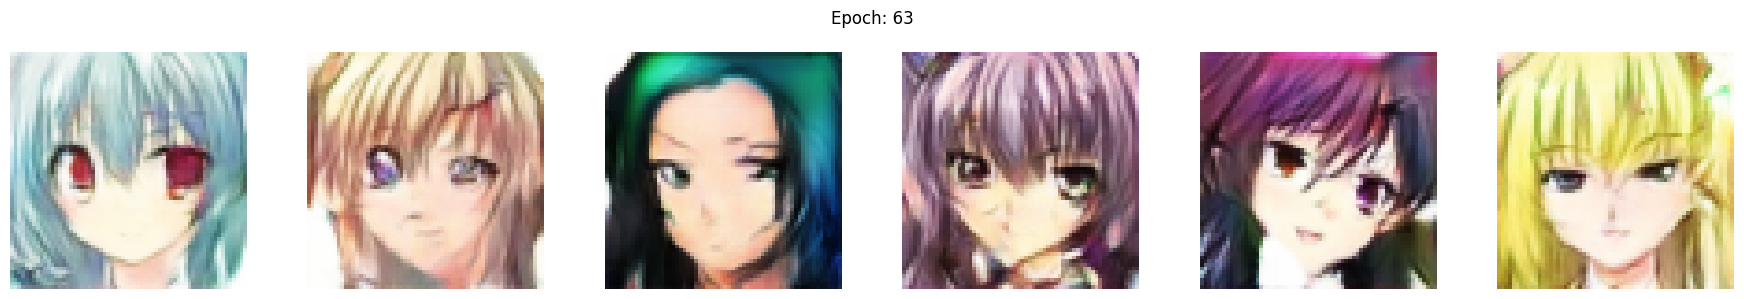

In [15]:
train_now()